# DengAI: Predicting Disease Spread
<h4>This project is being hosted by DrivenData.org with data input from NOAA and PERISANN. The purpose of this projet is to predict where the next outbreak of Dengue fever will be. The areas of predictions are San Juan, Puerto Rico and Iquitos, Peru. The task is to predict the number of dengue cases each week (in each location) based on environmental variables describing changes in temperature, precipitation, vegetation, and more.</h4>
<h4> This project will aim to predict the next outbreak through efficient EDA, feature engineering, regression modeling,seasonal decomposition and validating results through mean square error.</h4>
<img src='Map.png'>

## 1. Data Dictionary
 Below is a data dictionary describing what each column in the dataframe entitles. The columns will be analyzed and determined if any null values, measurement changes, imputing, removal, dropping, combining, or feature engineering are required in order for the data to be as clean and accurate as possible.

<h4>1.City and date indicators</h4><ul>
   <li><b>city</b> – City abbreviations: sj for San Juan and iq for Iquitos</li>
   <li><b>week_start_date</b> – Date given in yyyy-mm-dd format</li>

<h4>2.NOAA's GHCN daily climate data weather station measurements</h4>
   <li><b>station_max_temp_c</b> – Maximum temperature</li>
   <li><b>station_min_temp_c</b> – Minimum temperature</li>
   <li><b>station_avg_temp_c</b> – Average temperature</li>
   <li><b>station_precip_mm</b> – Total precipitation</li>
   <li><b> station_diur_temp_rng_c</b> – Diurnal temperature range

<h4>3.PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)</h4>
  <li><b> precipitation_amt_mm</b> – Total precipitation</li>

<h4>4.NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)</h4>
  <li><b> reanalysis_sat_precip_amt_mm</b> – Total precipitation</li>
  <li><b> reanalysis_dew_point_temp_k</b>– Mean dew point temperature</li>
  <li><b> reanalysis_air_temp_k</b> – Mean air temperature</li>
  <li><b> reanalysis_relative_humidity_percent</b> – Mean relative humidity</li>
  <li><b> reanalysis_specific_humidity_g_per_kg</b> – Mean specific humidity</li>
  <li><b> reanalysis_precip_amt_kg_per_m2</b> – Total precipitation</li>
  <li><b> reanalysis_max_air_temp_k</b> – Maximum air temperature</li>
  <li><b> reanalysis_min_air_temp_k</b> – Minimum air temperature</li>
  <li><b> reanalysis_avg_temp_k</b> – Average air temperature</li>
  <li><b> reanalysis_tdtr_k</b> – Diurnal temperature range</li>

<h4>5.Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements</h4>
  <li><b>ndvi_se</b> – Pixel southeast of city centroid</li>
  <li><b>ndvi_sw</b> – Pixel southwest of city centroid</li>
  <li><b>ndvi_ne</b> – Pixel northeast of city centroid</li>
  <li><b>ndvi_nw</b> – Pixel northwest of city centroid</li></ul>

### Load Files as .CSV

In [205]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from matplotlib import pyplot
%matplotlib inline

from scipy.stats import mode
from datetime import datetime
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,  make_scorer, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, Imputer, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
#Loaded dengue csv files
dengue = pd.read_csv('dengue_features_train.csv')
dengue_labels = pd.read_csv ('dengue_labels_train.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 2. Feature Engineering

##### First issue:
At the start of the project I thought it would be a good idea to do a classification model so I decided to change the city column to 0 and 1 but as the project progressed I decided it wasn't going to work and that my time would be better spent working on regression modeling and then using the timeseries modeling as a way to predict outbreaks. I want to keep this information here though, to show the progression of my thought process throughout the project and how as I examined the data and learned more about the purpose of the project I changed and focused my modeling on different aspects.

In [3]:
# First issue: changed the cities to 0 and 1 in case classification modeling is done.
#city_cat=dengue['city'].map(lambda x: 1 if x == 'sj' else 0)

In [4]:
# Added the new column to the dataset. I don't want to overwrite the city column since it is an intergal part of the preidcting
# model. So now the city column is kept and can be worked with while the new column can be used for classification purposes.
# Might be able to do KNN  or another clustering method to see if outbreaks can be predicted. Will look further into this idea
# and the possibilities espiecally since there seem 
#dengue['city_cat']=dengue['city'].map(lambda x: 1 if x == 'sj' else 0)

In [5]:
# New dataset with city added as a binary category
dengue.head(10)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,4/30/1990,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,5/7/1990,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,5/14/1990,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,5/21/1990,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,5/28/1990,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
5,sj,1990,23,6/4/1990,NaN,0.174850,0.254314,0.181743,9.58,299.630000,299.764286,295.851429,302.4,298.1,26.49,79.891429,9.58,17.212857,2.100000,28.114286,6.942857,34.4,23.9,39.1
6,sj,1990,24,6/11/1990,0.112900,0.092800,0.205071,0.210271,3.48,299.207143,299.221429,295.865714,301.3,297.7,38.60,82.000000,3.48,17.234286,2.042857,27.414286,6.771429,32.2,23.3,29.7
7,sj,1990,25,6/18/1990,0.072500,0.072500,0.151471,0.133029,151.12,299.591429,299.528571,296.531429,300.6,298.4,30.00,83.375714,151.12,17.977143,1.571429,28.371429,7.685714,33.9,22.8,21.1
8,sj,1990,26,6/25/1990,0.102450,0.146175,0.125571,0.123600,19.32,299.578571,299.557143,296.378571,302.1,297.7,37.51,82.768571,19.32,17.790000,1.885714,28.328571,7.385714,33.9,22.8,21.1
9,sj,1990,27,7/2/1990,NaN,0.121550,0.160683,0.202567,14.41,300.154286,300.278571,296.651429,302.3,298.7,28.40,81.281429,14.41,18.071429,2.014286,28.328571,6.514286,33.9,24.4,1.1


In [6]:
dengue.dtypes

city                                      object
year                                       int64
weekofyear                                 int64
week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rn

In [7]:
# Second issue: dealing with tempertaure conversation from C to F.
def celsius_to_fahren(temp_celsius):
    temp_fahren = (temp_celsius *1.8) + 32
    return temp_fahren

In [8]:
dengue['station_avg_temp_f'] = celsius_to_fahren(dengue.station_avg_temp_c)
dengue.drop(['station_avg_temp_c'], axis = 1, inplace=True)

In [9]:
dengue['station_max_temp_f'] = celsius_to_fahren(dengue.station_max_temp_c)
dengue.drop(['station_max_temp_c'], axis = 1, inplace=True)

In [10]:
dengue['station_min_temp_f'] = celsius_to_fahren(dengue.station_min_temp_c)
dengue.drop(['station_min_temp_c'], axis = 1, inplace=True)

In [11]:
dengue['station_diur_temp_rng_f'] = celsius_to_fahren(dengue.station_diur_temp_rng_c)
dengue.drop(['station_diur_temp_rng_c'], axis = 1, inplace=True)

In [12]:
# New dataset with tempertaures converted to Fahrenheit
dengue.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_precip_mm,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f
0,sj,1990,18,4/30/1990,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,16.0,77.797143,84.92,68.00,44.420000
1,sj,1990,19,5/7/1990,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,8.6,80.085714,89.06,71.96,43.468571
2,sj,1990,20,5/14/1990,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,41.4,80.085714,89.96,73.04,43.674286
3,sj,1990,21,5/21/1990,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,4.0,81.448571,91.94,73.94,44.188571
4,sj,1990,22,5/28/1990,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,5.8,84.097143,95.00,75.02,48.868571


In [13]:
# Third issue: convert mm to inches
def mm_to_inch(mm):
    inch = mm/25.4
    return inch

In [14]:
dengue['precipitation_amt_inch'] = mm_to_inch(dengue.precipitation_amt_mm)
dengue.drop(['precipitation_amt_mm'], axis = 1, inplace = True)

In [15]:
dengue['reanalysis_sat_precip_amt_inch'] = mm_to_inch(dengue.reanalysis_sat_precip_amt_mm)
dengue.drop(['reanalysis_sat_precip_amt_mm'], axis = 1, inplace = True)

In [16]:
dengue['station_precip_inch'] = mm_to_inch(dengue.station_precip_mm)
dengue.drop(['station_precip_mm'], axis = 1, inplace = True)

In [17]:
# New dataset with converted mm to inches
dengue.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f,precipitation_amt_inch,reanalysis_sat_precip_amt_inch,station_precip_inch
0,sj,1990,18,4/30/1990,0.122600,0.103725,0.198483,0.177617,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,14.012857,2.628571,77.797143,84.92,68.00,44.420000,0.488976,0.488976,0.629921
1,sj,1990,19,5/7/1990,0.169900,0.142175,0.162357,0.155486,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,15.372857,2.371429,80.085714,89.06,71.96,43.468571,0.898425,0.898425,0.338583
2,sj,1990,20,5/14/1990,0.032250,0.172967,0.157200,0.170843,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,16.848571,2.300000,80.085714,89.96,73.04,43.674286,1.359843,1.359843,1.629921
3,sj,1990,21,5/21/1990,0.128633,0.245067,0.227557,0.235886,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,16.672857,2.428571,81.448571,91.94,73.94,44.188571,0.604724,0.604724,0.157480
4,sj,1990,22,5/28/1990,0.196200,0.262200,0.251200,0.247340,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,17.210000,3.014286,84.097143,95.00,75.02,48.868571,0.296063,0.296063,0.228346


In [18]:
# Fourth issue: converted Kelvin to Fahrenheit
def kelvin_to_fahren(temp_kelvin):
    temp_fahren = (temp_kelvin *1.8) - 459.67
    return temp_fahren  

In [19]:
dengue['reanalysis_min_air_temp_f'] = kelvin_to_fahren(dengue.reanalysis_min_air_temp_k)
dengue.drop(['reanalysis_min_air_temp_k'], axis = 1, inplace = True)

In [20]:
dengue['reanalysis_air_temp_f'] = kelvin_to_fahren(dengue.reanalysis_air_temp_k)
dengue.drop(['reanalysis_air_temp_k'], axis = 1, inplace = True)

In [21]:
dengue['reanalysis_avg_temp_f'] = kelvin_to_fahren(dengue.reanalysis_avg_temp_k)
dengue.drop(['reanalysis_avg_temp_k'], axis = 1, inplace = True)

In [22]:
dengue['reanalysis_dew_point_temp_f'] = kelvin_to_fahren(dengue.reanalysis_dew_point_temp_k)
dengue.drop(['reanalysis_dew_point_temp_k'], axis = 1, inplace = True)

In [23]:
dengue['reanalysis_max_air_temp_f'] = kelvin_to_fahren(dengue.reanalysis_max_air_temp_k)
dengue.drop(['reanalysis_max_air_temp_k'], axis = 1, inplace = True)

In [24]:
dengue['reanalysis_tdtr_f'] = kelvin_to_fahren(dengue.reanalysis_tdtr_k)
dengue.drop(['reanalysis_tdtr_k'], axis = 1, inplace = True)

In [25]:
# New dataset with Kelvin converted to Fahrenheit
dengue.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f,precipitation_amt_inch,reanalysis_sat_precip_amt_inch,station_precip_inch,reanalysis_min_air_temp_f,reanalysis_air_temp_f,reanalysis_avg_temp_f,reanalysis_dew_point_temp_f,reanalysis_max_air_temp_f,reanalysis_tdtr_f
0,sj,1990,18,4/30/1990,0.122600,0.103725,0.198483,0.177617,32.00,73.365714,14.012857,77.797143,84.92,68.00,44.420000,0.488976,0.488976,0.629921,72.95,75.961143,76.267143,66.675714,79.97,-454.938571
1,sj,1990,19,5/7/1990,0.169900,0.142175,0.162357,0.155486,17.94,77.368571,15.372857,80.085714,89.06,71.96,43.468571,0.898425,0.898425,0.338583,73.85,77.110571,77.527143,69.442571,81.95,-455.401429
2,sj,1990,20,5/14/1990,0.032250,0.172967,0.157200,0.170843,26.10,82.052857,16.848571,80.085714,89.96,73.04,43.674286,1.359843,1.359843,1.629921,75.47,78.136571,78.311429,72.111714,81.23,-455.530000
3,sj,1990,21,5/21/1990,0.128633,0.245067,0.227557,0.235886,13.90,80.337143,16.672857,81.448571,91.94,73.94,44.188571,0.604724,0.604724,0.157480,74.93,78.506857,78.941429,71.888000,82.85,-455.298571
4,sj,1990,22,5/28/1990,0.196200,0.262200,0.251200,0.247340,12.20,80.460000,17.210000,84.097143,95.00,75.02,48.868571,0.296063,0.296063,0.228346,75.83,79.463429,79.725714,72.808571,83.75,-454.244286


In [26]:
# Fifth issue: Change date from object to datetime
dengue['week_start_date']=pd.to_datetime(dengue.week_start_date)
#dengue['week_start_date']= pd.to_numeric(dengue['week_start_date'])
#dengue['week_start_date'] = dengue['week_start_date'].astype('float64')

In [27]:
# New dataset with date converted to datetime instead of an object
dengue.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f,precipitation_amt_inch,reanalysis_sat_precip_amt_inch,station_precip_inch,reanalysis_min_air_temp_f,reanalysis_air_temp_f,reanalysis_avg_temp_f,reanalysis_dew_point_temp_f,reanalysis_max_air_temp_f,reanalysis_tdtr_f
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,32.00,73.365714,14.012857,77.797143,84.92,68.00,44.420000,0.488976,0.488976,0.629921,72.95,75.961143,76.267143,66.675714,79.97,-454.938571
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,17.94,77.368571,15.372857,80.085714,89.06,71.96,43.468571,0.898425,0.898425,0.338583,73.85,77.110571,77.527143,69.442571,81.95,-455.401429
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,26.10,82.052857,16.848571,80.085714,89.96,73.04,43.674286,1.359843,1.359843,1.629921,75.47,78.136571,78.311429,72.111714,81.23,-455.530000
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,13.90,80.337143,16.672857,81.448571,91.94,73.94,44.188571,0.604724,0.604724,0.157480,74.93,78.506857,78.941429,71.888000,82.85,-455.298571
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,12.20,80.460000,17.210000,84.097143,95.00,75.02,48.868571,0.296063,0.296063,0.228346,75.83,79.463429,79.725714,72.808571,83.75,-454.244286


In [28]:
# Sixth issue: kilogram per square meter to pound per square inch
def kgm2_to_lbin2(kg_per_m2):
    lb_per_in2 = (kg_per_m2 *.00142233)
    return lb_per_in2

In [29]:
dengue['reanalysis_precip_amt_lb_per_in2'] = kgm2_to_lbin2(dengue.reanalysis_precip_amt_kg_per_m2)
dengue.drop(['reanalysis_precip_amt_kg_per_m2'], axis = 1, inplace = True)

In [30]:
# New dataset with kilograms per square meters converted to pound per square inch
dengue.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f,precipitation_amt_inch,reanalysis_sat_precip_amt_inch,station_precip_inch,reanalysis_min_air_temp_f,reanalysis_air_temp_f,reanalysis_avg_temp_f,reanalysis_dew_point_temp_f,reanalysis_max_air_temp_f,reanalysis_tdtr_f,reanalysis_precip_amt_lb_per_in2
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,73.365714,14.012857,77.797143,84.92,68.00,44.420000,0.488976,0.488976,0.629921,72.95,75.961143,76.267143,66.675714,79.97,-454.938571,0.045515
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,77.368571,15.372857,80.085714,89.06,71.96,43.468571,0.898425,0.898425,0.338583,73.85,77.110571,77.527143,69.442571,81.95,-455.401429,0.025517
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,82.052857,16.848571,80.085714,89.96,73.04,43.674286,1.359843,1.359843,1.629921,75.47,78.136571,78.311429,72.111714,81.23,-455.530000,0.037123
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,80.337143,16.672857,81.448571,91.94,73.94,44.188571,0.604724,0.604724,0.157480,74.93,78.506857,78.941429,71.888000,82.85,-455.298571,0.019770
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,80.460000,17.210000,84.097143,95.00,75.02,48.868571,0.296063,0.296063,0.228346,75.83,79.463429,79.725714,72.808571,83.75,-454.244286,0.017352


In [31]:
# Seventh issue: gram per kilogram to grains per pound
def gperkg_to_grperlb(g_per_kg):
    gr_per_lb = (g_per_kg * 7)
    return gr_per_lb

In [32]:
dengue['reanalysis_specific_humidity_gr_per_lb'] = gperkg_to_grperlb(dengue.reanalysis_specific_humidity_g_per_kg)
dengue.drop(['reanalysis_specific_humidity_g_per_kg'], axis = 1, inplace = True)

In [33]:
# New dataset with converted grams per kilograms to grain per pound
dengue.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_relative_humidity_percent,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f,precipitation_amt_inch,reanalysis_sat_precip_amt_inch,station_precip_inch,reanalysis_min_air_temp_f,reanalysis_air_temp_f,reanalysis_avg_temp_f,reanalysis_dew_point_temp_f,reanalysis_max_air_temp_f,reanalysis_tdtr_f,reanalysis_precip_amt_lb_per_in2,reanalysis_specific_humidity_gr_per_lb
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,73.365714,77.797143,84.92,68.00,44.420000,0.488976,0.488976,0.629921,72.95,75.961143,76.267143,66.675714,79.97,-454.938571,0.045515,98.09
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,77.368571,80.085714,89.06,71.96,43.468571,0.898425,0.898425,0.338583,73.85,77.110571,77.527143,69.442571,81.95,-455.401429,0.025517,107.61
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,82.052857,80.085714,89.96,73.04,43.674286,1.359843,1.359843,1.629921,75.47,78.136571,78.311429,72.111714,81.23,-455.530000,0.037123,117.94
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,80.337143,81.448571,91.94,73.94,44.188571,0.604724,0.604724,0.157480,74.93,78.506857,78.941429,71.888000,82.85,-455.298571,0.019770,116.71
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,80.460000,84.097143,95.00,75.02,48.868571,0.296063,0.296063,0.228346,75.83,79.463429,79.725714,72.808571,83.75,-454.244286,0.017352,120.47


#### Summary of results
<h4>I made a judgement call to convert all the measurements from metrics to the US Standard system. I know in the end, once the data is normalizaled through sclaing it doesn't matter but I had very specfic reasons for doing these converstions. I wanted to have the data in a more understabdable format for myself. I'm going to be preforming deep analytical and stastical anaylais on it and I want it to be in measuremnets that I can comprehend. I also, wanted to show that I understand the concepts behind creating codes through definitions and how to convert different measurments gto different measurements.</h4>
<h4>The data is all converted, so I will be moving on to exploring the data, replacing,deleting null values, examining the data for duplications, conducting data comparisons between specific features which I sispect have correlations, and deleting features that aren't needed.</h4>
<h4>Later I will be creating new feature columns based on climate and environmental factors, in the hopes of better predicting outbreak areas.</h4>

## 3. Exploratory Data Analysis

In [34]:
# Brief look at dengue feature .csv. 1455 rows with 25 columns.
dengue.head(20)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_relative_humidity_percent,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f,precipitation_amt_inch,reanalysis_sat_precip_amt_inch,station_precip_inch,reanalysis_min_air_temp_f,reanalysis_air_temp_f,reanalysis_avg_temp_f,reanalysis_dew_point_temp_f,reanalysis_max_air_temp_f,reanalysis_tdtr_f,reanalysis_precip_amt_lb_per_in2,reanalysis_specific_humidity_gr_per_lb
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,73.365714,77.797143,84.92,68.00,44.420000,0.488976,0.488976,0.629921,72.95,75.961143,76.267143,66.675714,79.97,-454.938571,0.045515,98.09
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,77.368571,80.085714,89.06,71.96,43.468571,0.898425,0.898425,0.338583,73.85,77.110571,77.527143,69.442571,81.95,-455.401429,0.025517,107.61
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,82.052857,80.085714,89.96,73.04,43.674286,1.359843,1.359843,1.629921,75.47,78.136571,78.311429,72.111714,81.23,-455.530000,0.037123,117.94
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,80.337143,81.448571,91.94,73.94,44.188571,0.604724,0.604724,0.157480,74.93,78.506857,78.941429,71.888000,82.85,-455.298571,0.019770,116.71
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,80.460000,84.097143,95.00,75.02,48.868571,0.296063,0.296063,0.228346,75.83,79.463429,79.725714,72.808571,83.75,-454.244286,0.017352,120.47
5,sj,1990,23,1990-06-04,NaN,0.174850,0.254314,0.181743,79.891429,82.605714,93.92,75.02,44.497143,0.377165,0.377165,1.539370,76.91,79.664000,79.905714,72.862571,84.65,-455.890000,0.037678,120.49
6,sj,1990,24,1990-06-11,0.112900,0.092800,0.205071,0.210271,82.000000,81.345714,89.96,73.94,44.188571,0.137008,0.137008,1.169291,76.19,78.902857,78.928571,72.888286,82.67,-455.992857,0.054902,120.64
7,sj,1990,25,1990-06-18,0.072500,0.072500,0.151471,0.133029,83.375714,83.068571,93.02,73.04,45.834286,5.949606,5.949606,0.830709,77.45,79.594571,79.481429,74.086571,81.41,-456.841429,0.042670,125.84
8,sj,1990,26,1990-06-25,0.102450,0.146175,0.125571,0.123600,82.768571,82.991429,93.02,73.04,45.294286,0.760630,0.760630,0.830709,76.19,79.571429,79.532857,73.811429,84.11,-456.275714,0.053352,124.53
9,sj,1990,27,1990-07-02,NaN,0.121550,0.160683,0.202567,81.281429,82.991429,93.02,75.92,43.725714,0.567323,0.567323,0.043307,77.99,80.607714,80.831429,74.302571,84.47,-456.044286,0.040394,126.50


In [35]:
# Duplicate columns expect for total_cases. 
dengue_labels.head(10)

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6
5,sj,1990,23,2
6,sj,1990,24,4
7,sj,1990,25,5
8,sj,1990,26,10
9,sj,1990,27,6


In [36]:
# Joined the two datsets so the total_cases would be part of the main dataset.
#dengue.merge(dengue_labels['total_cases']

#dengue_new = dengue.append(dengue_labels['total_cases'], axis=1)

#result = pd.merge(dengue,dengue_labels[['total_cases']], on='weekofyear')
#result.head()

#pd.merge(dengue, dengue_labels[['total_cases']], how='right', on='weekofyear')

dengue_new= dengue.join(dengue_labels[['total_cases']], how='right')

In [37]:
dengue =(dengue.join(dengue_labels[['total_cases']], how='right'))

In [38]:
# There seem to be a number of null values that need to be explored. Most of the data seem to be int or floats which is good.
# Week start date is an object, not sure if that data type will have to be changed. The week of the year is an int so there maybe
# no need to, but I'll have to remember that this may cause an issue later on. City is also an object, if I want to go the
# the clasification route and try and predict total cases that way I made need to change the type so it can be dummizied. That's
# another option to look into.
dengue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 25 columns):
city                                      1456 non-null object
year                                      1456 non-null int64
weekofyear                                1456 non-null int64
week_start_date                           1456 non-null datetime64[ns]
ndvi_ne                                   1262 non-null float64
ndvi_nw                                   1404 non-null float64
ndvi_se                                   1434 non-null float64
ndvi_sw                                   1434 non-null float64
reanalysis_relative_humidity_percent      1446 non-null float64
station_avg_temp_f                        1413 non-null float64
station_max_temp_f                        1436 non-null float64
station_min_temp_f                        1442 non-null float64
station_diur_temp_rng_f                   1413 non-null float64
precipitation_amt_inch                    1443 non-null flo

In [39]:
# NaN values that have to be looked at and determined whether to be dropped or imputered/dummizied.
dengue.isnull().sum()[dengue.isnull().sum()>0]

ndvi_ne                                   194
ndvi_nw                                    52
ndvi_se                                    22
ndvi_sw                                    22
reanalysis_relative_humidity_percent       10
station_avg_temp_f                         43
station_max_temp_f                         20
station_min_temp_f                         14
station_diur_temp_rng_f                    43
precipitation_amt_inch                     13
reanalysis_sat_precip_amt_inch             13
station_precip_inch                        22
reanalysis_min_air_temp_f                  10
reanalysis_air_temp_f                      10
reanalysis_avg_temp_f                      10
reanalysis_dew_point_temp_f                10
reanalysis_max_air_temp_f                  10
reanalysis_tdtr_f                          10
reanalysis_precip_amt_lb_per_in2           10
reanalysis_specific_humidity_gr_per_lb     10
dtype: int64

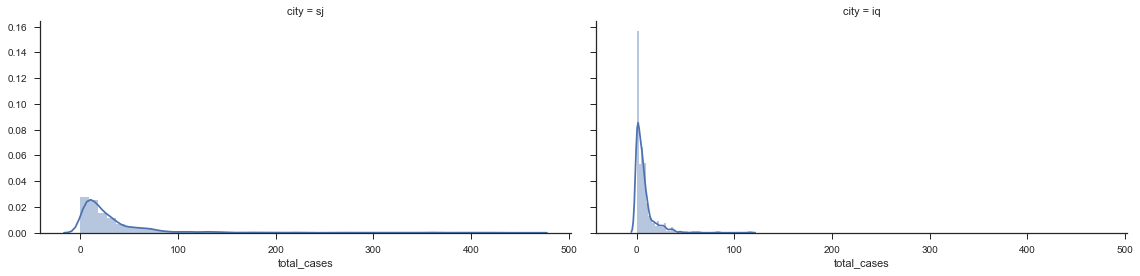

In [40]:
# There definitly seems to be a higher total amount of cases in a certain time period Peru vs Puerto Rico
# but Puerto Rico is more consistent in its amount  of cases. It seems to be Puero has a certain time of year that it peaks while
# Puerto Rico has cases all year but at a low level.
figsize = (14, 12)
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(dengue, col="city", aspect = 2, size = 4)
g.map(sns.distplot, "total_cases")
None

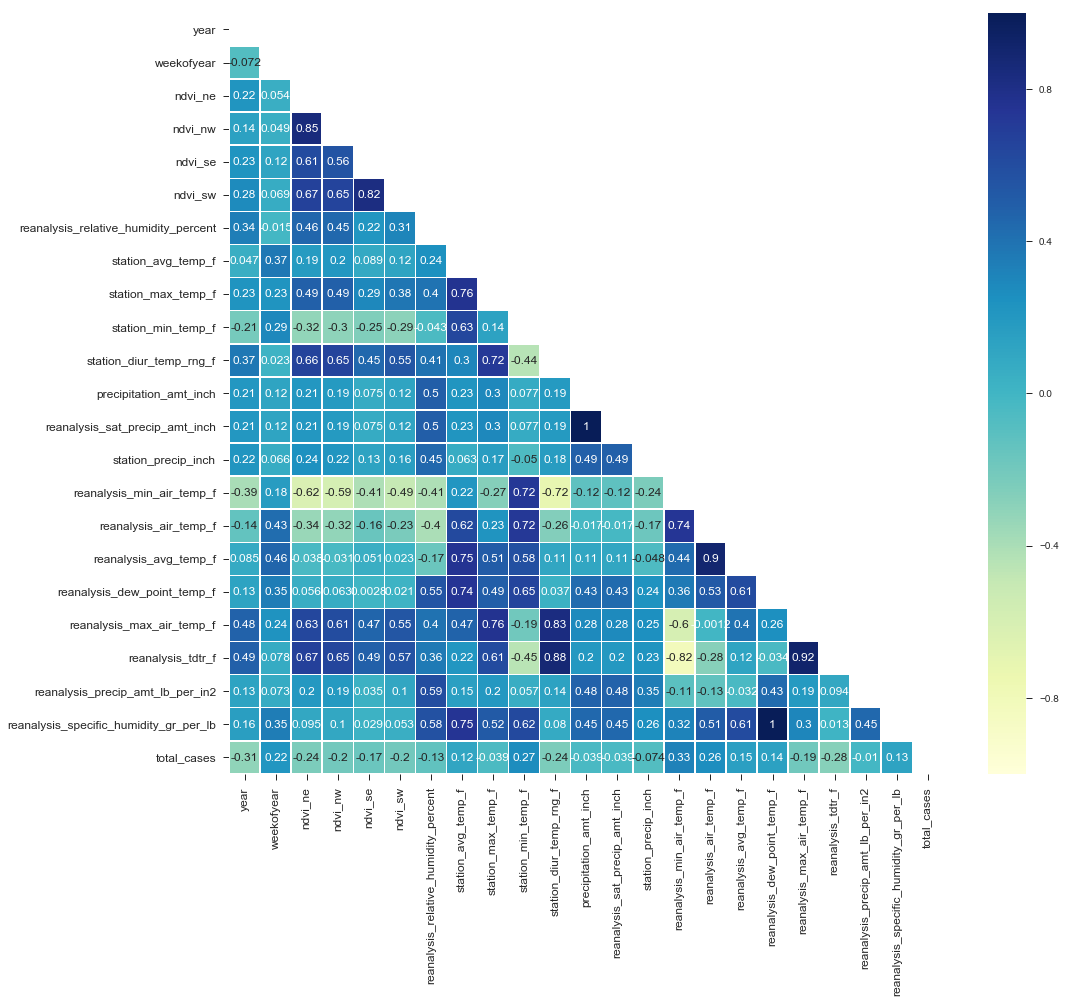

In [41]:
corr = dengue.corr()

fig, ax = plt.subplots(figsize=(16,14))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, mask=mask, ax=ax, annot=True, cmap="YlGnBu",  linewidths=.5)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12)

plt.show()

##### Analysis of Heatmap
<h4>First looking at the heatmap in general, there are some very strong correlations between reanalysis specific humidity and reanalysis of dew point also between reanalysis saturated precipitation amount and preceipitation amount which leads me to believe there is eitehr mutlcolinearity here or these columns are duplicate values. Theses will be examined to determine if either assumption is true. There are others that have high correlations but I need to do more research on exactly what the data means before I can draw further conclusions. That will be flushed out in the EDA and further analysis section if necessary.</h4>
<h4>The target for this project is total cases. There aren't very strong correlations with any feature. Which may work in my favor. Too high of correlation can be due to multicolinarity or that the features share a common identifier in common. At this point, it's too early to start discounting features yet. A few I do know, based on biology and epidemology, is that mosquitos grow the best in warm wets climates and can survive to temperatures  as low as of 40 fahrenheit. So temperature, amount of rain, and in particular amount of rain during certain seasons such as spring and summer should be examined closely.</h4>

In [42]:
# As mentioned above the correlation values aren't very high, but again, that isn't a negative aspect. It can be an inverse
# effect  whichcan be helpful. For example, year is negative but with more analysis and feature engineering year can be very 
# helpful based on the seasons. The other features need to be researched more and it looks like the tenperatures aren't all in
# the same degree. That will have to be rectified and may change the correlation values.
dengue.corr()['total_cases'].sort_values(ascending=False)

total_cases                               1.000000
reanalysis_min_air_temp_f                 0.325252
station_min_temp_f                        0.267109
reanalysis_air_temp_f                     0.264952
weekofyear                                0.216452
reanalysis_avg_temp_f                     0.151637
reanalysis_dew_point_temp_f               0.142531
reanalysis_specific_humidity_gr_per_lb    0.129861
station_avg_temp_f                        0.116109
reanalysis_precip_amt_lb_per_in2         -0.010031
precipitation_amt_inch                   -0.038740
reanalysis_sat_precip_amt_inch           -0.038740
station_max_temp_f                       -0.039219
station_precip_inch                      -0.074374
reanalysis_relative_humidity_percent     -0.132452
ndvi_se                                  -0.168612
reanalysis_max_air_temp_f                -0.191345
ndvi_sw                                  -0.196461
ndvi_nw                                  -0.202235
station_diur_temp_rng_f        

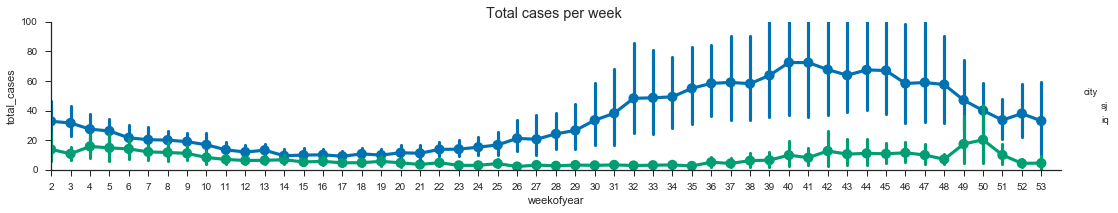

In [43]:
#
sns.set(style="ticks", palette="colorblind")
fig = sns.FacetGrid(dengue, hue='city', aspect=5) 
fig.map(sns.pointplot,'weekofyear','total_cases')
max_x = dengue.weekofyear.max()
min_x = dengue.weekofyear.min()
fig.set(xlim=(min_x,max_x))
fig.set(ylim=(0, 100))
fig.add_legend()
fig.fig.suptitle("Total cases per week")
None

In [44]:
# Relative humidity, expressed as a percent, measures the current absolute humidity relative to the maximum (highest point) for 
# that temperature. Specific humidity is the ratio of the mass of water vapor to the total mass of the moist air parcel.This was 
# taken from a website since I was trying to find a correlation between the two features.
# It's hard to compare these two values since they are different units of measure. They are related since they both have to do
# with degree of humidity. There is no clear relationship as a high percentage can have a lower humdity per grain per pound.
# I'm sure there are other factors that effect the humdity such as the amount of rain fall that particular day or the tempertaure
# since humidity usually does have a correlation with high tempertaures and the amount of water vapor in the air.
# I'm not sure how this would relate to mosquito growth. I belive tempertaure and actual amount of rain are better routes to take.
# I'm not going to get rid of the columns but I probably will not be using them as a predictive factor.
dengue[['reanalysis_relative_humidity_percent', 'reanalysis_specific_humidity_gr_per_lb']].head(10)

,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_gr_per_lb
0,73.365714,98.09
1,77.368571,107.61
2,82.052857,117.94
3,80.337143,116.71
4,80.460000,120.47
5,79.891429,120.49
6,82.000000,120.64
7,83.375714,125.84
8,82.768571,124.53
9,81.281429,126.50


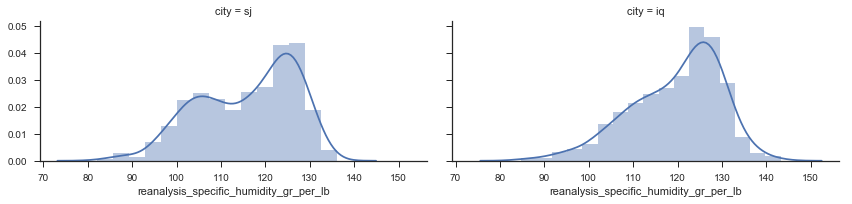

In [45]:
# The two cities are very similar in specific humidity which maybe an indicator as to why the mosquitoes are so prevelant there.
# Peru is slightly higher but both peak around the same point about 125 gr/lb.
figsize = (14, 12)
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(dengue, col="city", aspect =2)
g.map(sns.distplot, "reanalysis_specific_humidity_gr_per_lb")
None

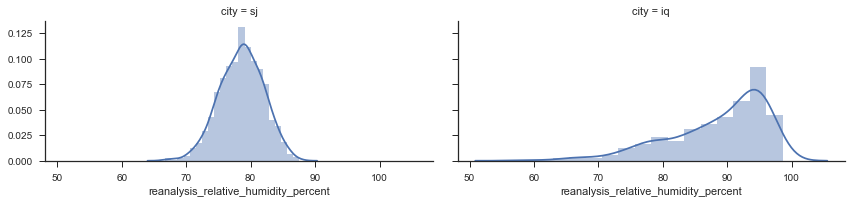

In [46]:
# Puerto Rico has a very normal distribution compared to Peru. This coudl be why Puerto Rico has a year round level of cases 
# while Peru definitly peaks at one point during the year and that is probably when the outbreaks are at their highest.
figsize = (14, 12)
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(dengue, col="city", aspect =2)
g.map(sns.distplot, "reanalysis_relative_humidity_percent")
None

In [47]:
# The following are 9 columns that have NaN values for 10 rows. 
#nans = dengue[['reanalysis_air_temp_f','reanalysis_avg_temp_f','reanalysis_dew_point_temp_f','reanalysis_max_air_temp_f',
        #'reanalysis_min_air_temp_f','reanalysis_precip_amt_lb_per_in2','reanalysis_relative_humidity_percent',
        #'reanalysis_specific_humidity_gr_per_lb','reanalysis_tdtr_f']]

In [48]:
#nans[nans.isnull().any(axis=1)]
#nans[np.isnan(nans)]

In [49]:
# These are the rows to be dropped. 
#dengue.drop(87, inplace = True)
#dengue.drop(139, inplace = True)
#dengue.drop(399, inplace = True)
#dengue.drop(451, inplace = True)
#dengue.drop(711, inplace = True)
#dengue.drop(763, inplace = True)
#dengue.drop(1118, inplace = True)
#dengue.drop(1170, inplace = True)
#dengue.drop(1378, inplace = True)
#dengue.drop(1430, inplace = True)

##### Analysis of 10 rows of NaN values

<h4>I could imputer or at least fillna but I don't see the benefit. I think having 0 would be more determinal to the data then keeping it. The data is spread over multiple years and seasons. I don't know what year or week each indexed row is. In order to accurately imputer the needed information I would have to go by year and week and imputer based on the seasonality. I think there comes a point where the amount of work to create data that for some unknown reason was never recorded becasue specious and a danger to the integrity of the the entire dataset. Due to these reasons I will be dropping these 10 rows.</h4>
<h4>*Update* This rows can't be dropped. Upon submission of my data to Drivendata.org, my submission was rejection due to invalid amount of rows. So since I have to do to my test set what I did to my train set, I can't drop the rows. Instead I will do a fillna and to these rows.</h4>

In [50]:
# There are 189 NaN values. Trying to imputer these would be possible but with so many missing I dont know how accurate I would
# be since these are dependent on seasons and I woudl have to break down the data based on the seasons. I think this is like the 
# the rows that were dropped from before. It would be more harm to just imputer values that may or may not be accurate and yield
# vaild results. Instead I will drop the column. There are three others that have less null values and those I will work on 
# determining how to, the best of my ability, accurately imputer.
dengue.ndvi_ne.isnull().sum()

194

In [51]:
# Dropping column.
dengue.drop('ndvi_ne', axis = 1, inplace = True)

In [52]:
# Since the measurements have to deal with vegetation in an areas, I wanted to get a sense of what the timeframe of the year was
# this way I could more accurately pick a more accurate measurement. 
#dengue.ndvi_nw.sort_values(na_position='first').index()<0
#dengue.loc[dengue.ndvi_nw.index.isnull()]
dengue[np.isnan(dengue['ndvi_nw'])]

,city,year,weekofyear,week_start_date,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_relative_humidity_percent,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f,precipitation_amt_inch,reanalysis_sat_precip_amt_inch,station_precip_inch,reanalysis_min_air_temp_f,reanalysis_air_temp_f,reanalysis_avg_temp_f,reanalysis_dew_point_temp_f,reanalysis_max_air_temp_f,reanalysis_tdtr_f,reanalysis_precip_amt_lb_per_in2,reanalysis_specific_humidity_gr_per_lb,total_cases
45,sj,1991,11,1991-03-12,NaN,0.213250,0.240543,78.138571,78.671429,89.06,69.08,48.148571,0.000000,0.000000,0.141732,72.59,75.706571,76.074286,68.334286,80.51,-454.758571,0.019017,103.51,17
62,sj,1991,28,1991-07-09,NaN,0.138050,0.167917,77.877143,83.145714,91.04,75.92,44.008571,0.241339,0.241339,0.181102,76.55,80.332571,80.638571,72.754571,84.11,-455.298571,0.026598,120.06,14
65,sj,1991,31,1991-07-30,NaN,0.190643,0.159329,81.897143,83.428571,91.94,77.00,43.417143,1.905906,1.905906,0.708661,77.27,80.065143,80.265714,73.991429,83.93,-455.530000,0.048914,125.15,25
67,sj,1991,33,1991-08-13,NaN,0.155100,0.156700,79.197143,84.971429,91.94,78.08,41.848571,0.000000,0.000000,0.129921,77.99,81.086000,81.500000,74.001714,85.37,-455.735714,0.029016,125.38,60
99,sj,1992,13,1992-03-25,NaN,0.134843,0.106800,80.238571,79.160000,89.96,71.96,42.285714,0.000000,0.000000,0.090551,72.77,75.323429,75.701429,68.771429,80.87,-454.630000,0.029869,104.78,29
108,sj,1992,22,1992-05-27,NaN,0.219157,0.213014,87.301429,81.371429,89.06,75.02,42.722857,7.332677,7.332677,3.157480,74.93,77.838286,78.080000,73.731714,82.85,-455.427143,0.185330,124.83,20
139,sj,1993,53,1993-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30
162,sj,1993,23,1993-06-11,NaN,0.153771,0.148486,80.615714,85.820000,93.92,77.00,45.294286,0.333858,0.333858,0.051181,77.63,81.515429,81.654286,74.891429,85.37,-454.912857,0.028731,129.44,12
181,sj,1993,42,1993-10-22,NaN,0.134700,0.149686,78.807143,82.760000,91.94,75.02,45.860000,0.000000,0.000000,0.251969,76.73,80.656571,80.767143,73.433429,84.65,-455.607143,0.024180,123.15,38
188,sj,1993,49,1993-12-10,NaN,0.163233,0.082833,80.302857,79.751429,87.08,69.98,44.754286,0.208268,0.208268,0.818898,74.21,77.123429,77.077143,70.466000,81.23,-455.427143,0.061729,111.53,31


In [53]:
# Imputing the missing values
print(dengue['ndvi_nw'].describe())

print('Mode', mode(dengue['ndvi_nw']))

strategy = 'median' 

ndvinw_imputer = Imputer(strategy=strategy)
ndvinw_imputer.fit(dengue[['ndvi_nw']])

NWs = ndvinw_imputer.transform(
    dengue[['ndvi_nw']])
print(NWs[0:5], NWs.mean())
# Imputered the missing values and added them to the column.
dengue[['ndvi_nw']]=NWs

count    1404.000000
mean        0.130553
std         0.119999
min        -0.456100
25%         0.049217
50%         0.121429
75%         0.216600
max         0.454429
Name: ndvi_nw, dtype: float64
Mode ModeResult(mode=array([ 0.0278]), count=array([3]))
[[ 0.103725 ]
 [ 0.142175 ]
 [ 0.1729667]
 [ 0.2450667]
 [ 0.2622   ]] 0.130226719815


In [54]:
# Examining the missing  null values
dengue[np.isnan(dengue['ndvi_se'])]

,city,year,weekofyear,week_start_date,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_relative_humidity_percent,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f,precipitation_amt_inch,reanalysis_sat_precip_amt_inch,station_precip_inch,reanalysis_min_air_temp_f,reanalysis_air_temp_f,reanalysis_avg_temp_f,reanalysis_dew_point_temp_f,reanalysis_max_air_temp_f,reanalysis_tdtr_f,reanalysis_precip_amt_lb_per_in2,reanalysis_specific_humidity_gr_per_lb,total_cases
139,sj,1993,53,1993-01-01,0.121429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30
191,sj,1994,52,1994-01-01,0.121429,NaN,NaN,78.018571,80.548571,91.04,71.06,46.760000,0.206693,0.206693,0.011811,73.13,77.678857,78.131429,70.252571,82.13,-455.272857,0.004836,110.46,22
229,sj,1994,38,1994-09-24,0.121429,NaN,NaN,79.314286,83.068571,89.96,75.92,43.134286,1.544094,1.544094,1.350394,76.91,80.124286,80.394286,73.060571,84.47,-456.095714,0.072112,121.48,302
230,sj,1994,39,1994-10-01,0.121429,NaN,NaN,80.372857,82.425714,93.02,73.94,44.060000,2.200000,2.200000,1.240157,76.19,79.445429,79.687143,72.808571,83.57,-454.990000,0.064289,120.74,395
231,sj,1994,40,1994-10-08,0.121429,NaN,NaN,74.117143,83.685714,93.92,75.92,44.420000,0.024803,0.024803,0.322835,77.99,81.008857,81.230000,71.983143,84.83,-454.938571,0.003983,117.21,426
232,sj,1994,41,1994-10-15,0.121429,NaN,NaN,78.225714,82.991429,95.00,75.02,45.782857,0.657480,0.657480,1.543307,76.37,79.679429,79.648571,72.196571,85.55,-454.758571,0.058031,118.30,461
233,sj,1994,42,1994-10-22,0.121429,NaN,NaN,76.348571,83.428571,95.00,75.02,45.397143,2.975197,2.975197,0.212598,77.27,80.759429,81.050000,72.564286,85.73,-454.218571,0.022487,119.87,381
234,sj,1994,43,1994-10-29,0.121429,NaN,NaN,85.417143,81.808571,91.04,73.94,45.088571,4.390551,4.390551,1.543307,75.83,78.190571,78.272857,73.438571,81.23,-456.687143,0.092238,123.49,333
235,sj,1994,44,1994-11-05,0.121429,NaN,NaN,78.685714,82.682857,89.96,75.92,44.317143,0.212992,0.212992,0.074803,77.27,80.090857,80.420000,72.852286,83.75,-455.478571,0.022188,120.85,353
236,sj,1994,45,1994-11-12,0.121429,NaN,NaN,80.095714,81.165714,89.06,71.96,44.471429,1.270079,1.270079,2.145669,75.29,79.064857,78.761429,72.374000,83.03,-455.658571,0.052057,118.89,410


In [55]:
# Imputing the missing values
print(dengue['ndvi_se'].describe())

print('Mode', mode(dengue['ndvi_se']))

strategy = 'median' 

ndvise_imputer = Imputer(strategy=strategy)
ndvise_imputer.fit(dengue[['ndvi_se']])

SEs = ndvise_imputer.transform(
    dengue[['ndvi_se']])
print(SEs[0:5], SEs.mean())
# Imputered the missing values and added them to the column.
dengue[['ndvi_se']]=SEs

count    1434.000000
mean        0.203783
std         0.073860
min        -0.015533
25%         0.155087
50%         0.196050
75%         0.248846
max         0.538314
Name: ndvi_se, dtype: float64
Mode ModeResult(mode=array([ 0.08821429]), count=array([2]))
[[ 0.1984833]
 [ 0.1623571]
 [ 0.1572   ]
 [ 0.2275571]
 [ 0.2512   ]] 0.203666341389


In [56]:
# Examining the missing null values
dengue[np.isnan(dengue['ndvi_sw'])]

,city,year,weekofyear,week_start_date,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_relative_humidity_percent,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f,precipitation_amt_inch,reanalysis_sat_precip_amt_inch,station_precip_inch,reanalysis_min_air_temp_f,reanalysis_air_temp_f,reanalysis_avg_temp_f,reanalysis_dew_point_temp_f,reanalysis_max_air_temp_f,reanalysis_tdtr_f,reanalysis_precip_amt_lb_per_in2,reanalysis_specific_humidity_gr_per_lb,total_cases
139,sj,1993,53,1993-01-01,0.121429,0.19605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30
191,sj,1994,52,1994-01-01,0.121429,0.19605,NaN,78.018571,80.548571,91.04,71.06,46.760000,0.206693,0.206693,0.011811,73.13,77.678857,78.131429,70.252571,82.13,-455.272857,0.004836,110.46,22
229,sj,1994,38,1994-09-24,0.121429,0.19605,NaN,79.314286,83.068571,89.96,75.92,43.134286,1.544094,1.544094,1.350394,76.91,80.124286,80.394286,73.060571,84.47,-456.095714,0.072112,121.48,302
230,sj,1994,39,1994-10-01,0.121429,0.19605,NaN,80.372857,82.425714,93.02,73.94,44.060000,2.200000,2.200000,1.240157,76.19,79.445429,79.687143,72.808571,83.57,-454.990000,0.064289,120.74,395
231,sj,1994,40,1994-10-08,0.121429,0.19605,NaN,74.117143,83.685714,93.92,75.92,44.420000,0.024803,0.024803,0.322835,77.99,81.008857,81.230000,71.983143,84.83,-454.938571,0.003983,117.21,426
232,sj,1994,41,1994-10-15,0.121429,0.19605,NaN,78.225714,82.991429,95.00,75.02,45.782857,0.657480,0.657480,1.543307,76.37,79.679429,79.648571,72.196571,85.55,-454.758571,0.058031,118.30,461
233,sj,1994,42,1994-10-22,0.121429,0.19605,NaN,76.348571,83.428571,95.00,75.02,45.397143,2.975197,2.975197,0.212598,77.27,80.759429,81.050000,72.564286,85.73,-454.218571,0.022487,119.87,381
234,sj,1994,43,1994-10-29,0.121429,0.19605,NaN,85.417143,81.808571,91.04,73.94,45.088571,4.390551,4.390551,1.543307,75.83,78.190571,78.272857,73.438571,81.23,-456.687143,0.092238,123.49,333
235,sj,1994,44,1994-11-05,0.121429,0.19605,NaN,78.685714,82.682857,89.96,75.92,44.317143,0.212992,0.212992,0.074803,77.27,80.090857,80.420000,72.852286,83.75,-455.478571,0.022188,120.85,353
236,sj,1994,45,1994-11-12,0.121429,0.19605,NaN,80.095714,81.165714,89.06,71.96,44.471429,1.270079,1.270079,2.145669,75.29,79.064857,78.761429,72.374000,83.03,-455.658571,0.052057,118.89,410


In [57]:
# Imputing the missing values
print(dengue['ndvi_sw'].describe())

print('Mode', mode(dengue['ndvi_sw']))

strategy = 'median' 

ndvisw_imputer = Imputer(strategy=strategy)
ndvisw_imputer.fit(dengue[['ndvi_sw']])

SWs = ndvise_imputer.transform(
    dengue[['ndvi_sw']])
print(SWs[0:5], SWs.mean())
# Imputered the missing values and added them to the column.
dengue[['ndvi_sw']]=SWs

count    1434.000000
mean        0.202305
std         0.083903
min        -0.063457
25%         0.144209
50%         0.189450
75%         0.246982
max         0.546017
Name: ndvi_sw, dtype: float64
Mode ModeResult(mode=array([ 0.1688714]), count=array([3]))
[[ 0.1776167]
 [ 0.1554857]
 [ 0.1708429]
 [ 0.2358857]
 [ 0.24734  ]] 0.202210970934


##### Analysis on Imputing ndvi_ nulls
<h4> Two issues with imputing ndvi_nw,se,sw: 1. I wasn't happy that I couldn't give accurate accounts. The data for indicies 229-242, are at least all in the same year and season so the data I created shouldn't be too far off actually accounts. For the other years and especially for nw, which had many more null values, I'm concerned the data will be off.</h4>
<h4> 2. If I had more time to learn and experiment with manually creating the data by doing it by season I would have. But it comes to a point in a project, where a choice has to be made on whether to spend an exorbitant amount of time going through hundreds of rows and figuring out the data manually or just imputing the values and spend more time building a strong unbiased model.</h4>
<h4>I decide to spend the time working on the models and learning seasonal decompose to try and accurately predict outbreaks other ways. I will keep these sets in mind when looking at data so I can remind myself that these data points were created and weren't actually recorded for one reason or another.</h4>

C:\Users\emmag\Anaconda3\lib\site-packages\matplotlib\cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


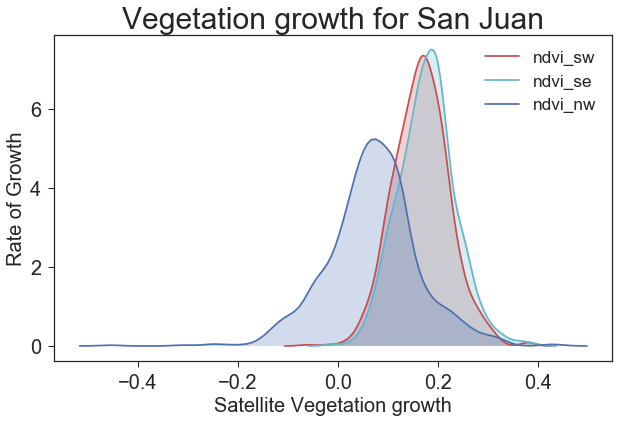

In [269]:
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.kdeplot(dengue_sj.ndvi_sw, shade=True,c='r', label='ndvi_sw')
ax = sns.kdeplot(dengue_sj.ndvi_se, shade=True, c='c', label='ndvi_se')
ax = sns.kdeplot(dengue_sj.ndvi_nw, shade=True, c='b', label='ndvi_nw')

plt.xlabel('Satellite Vegetation growth', fontsize=20)
plt.ylabel('Rate of Growth', fontsize=20)
plt.title('Vegetation growth for San Juan', fontsize=30)
ax.legend(fontsize='xx-large')
ax.tick_params(labelsize=20);

C:\Users\emmag\Anaconda3\lib\site-packages\matplotlib\cbook.py:2649: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


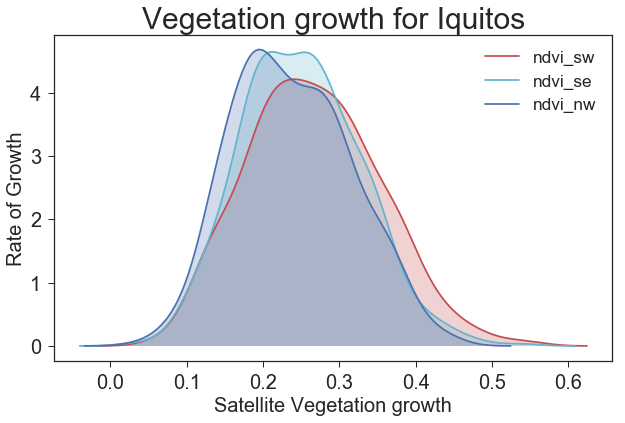

In [271]:
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.kdeplot(dengue_iq.ndvi_sw, shade=True,c='r', label='ndvi_sw')
ax = sns.kdeplot(dengue_iq.ndvi_se, shade=True, c='c', label='ndvi_se')
ax = sns.kdeplot(dengue_iq.ndvi_nw, shade=True, c='b', label='ndvi_nw')

plt.xlabel('Satellite Vegetation growth', fontsize=20)
plt.ylabel('Rate of Growth', fontsize=20)
plt.title('Vegetation growth for Iquitos', fontsize=30)
ax.legend(fontsize='xx-large')
ax.tick_params(labelsize=20);

##### Analysis of vegetation graphs

In [58]:
#dengue[np.isnan(dengue[['station_avg_temp_f','station_max_temp_f','station_min_temp_f','station_diur_temp_rng_f',
 #      'precipitation_amt_inch','reanalysis_sat_precip_amt_inch','station_precip_inch']])]
nans = dengue[['station_avg_temp_f','station_max_temp_f','station_min_temp_f','station_diur_temp_rng_f',
               'reanalysis_sat_precip_amt_inch','station_precip_inch']]

In [59]:
nans[nans.isnull().any(axis=1)]

,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f,reanalysis_sat_precip_amt_inch,station_precip_inch
87,NaN,NaN,NaN,NaN,NaN,NaN
93,78.851429,89.96,68.00,43.828571,NaN,0.051181
94,78.362857,93.02,71.06,45.294286,NaN,0.350394
95,77.514286,84.92,71.06,43.108571,NaN,0.629921
139,NaN,NaN,NaN,NaN,NaN,NaN
399,NaN,NaN,NaN,NaN,NaN,NaN
451,NaN,NaN,NaN,NaN,NaN,NaN
711,NaN,NaN,NaN,NaN,NaN,NaN
763,NaN,NaN,NaN,NaN,NaN,NaN
957,81.860000,97.70,70.70,52.430000,2.201181,NaN


In [60]:
# Imputing the missing values
print(dengue['station_min_temp_f'].describe())

print('Mode', mode(dengue['station_min_temp_f']))

strategy = 'median' 

stamintemp_imputer = Imputer(strategy=strategy)
stamintemp_imputer.fit(dengue[['station_min_temp_f']])

SMTFs = stamintemp_imputer.transform(
    dengue[['station_min_temp_f']])
print(SMTFs[0:5], SMTFs.mean())
# Imputered the missing values and added them to the column.
dengue[['station_min_temp_f']]=SMTFs

count    1442.000000
mean       71.783870
std         2.833319
min        58.460000
25%        69.980000
50%        71.960000
75%        73.940000
max        78.080000
Name: station_min_temp_f, dtype: float64
Mode ModeResult(mode=array([ 75.02]), count=array([135]))
[[ 68.  ]
 [ 71.96]
 [ 73.04]
 [ 73.94]
 [ 75.02]] 71.7855631868


In [61]:
# Imputing the missing values
print(dengue['reanalysis_sat_precip_amt_inch'].describe())

print('Mode', mode(dengue['reanalysis_sat_precip_amt_inch']))

strategy = 'median' 

resaprep_imputer = Imputer(strategy=strategy)
resaprep_imputer.fit(dengue[['reanalysis_sat_precip_amt_inch']])

RSPAIs = resaprep_imputer.transform(
    dengue[['reanalysis_sat_precip_amt_inch']])
print(RSPAIs[0:5], RSPAIs.mean())
# Imputered the missing values and added them to the column.
dengue[['reanalysis_sat_precip_amt_inch']]=RSPAIs

count    1443.000000
mean        1.801590
std         1.721084
min         0.000000
25%         0.385827
50%         1.509449
75%         2.765157
max        15.377953
Name: reanalysis_sat_precip_amt_inch, dtype: float64
Mode ModeResult(mode=array([ 0.]), count=array([239]))
[[ 0.48897638]
 [ 0.8984252 ]
 [ 1.35984252]
 [ 0.60472441]
 [ 0.29606299]] 1.79898167777


In [62]:
# Imputing the missing values
print(dengue['station_max_temp_f'].describe())

print('Mode', mode(dengue['station_max_temp_f']))

strategy = 'median' 

stamaxtemp_imputer = Imputer(strategy=strategy)
stamaxtemp_imputer.fit(dengue[['station_max_temp_f']])

STFs = stamaxtemp_imputer.transform(
    dengue[['station_max_temp_f']])
print(STFs[0:5], STFs.mean())
# Imputered the missing values and added them to the column.
dengue[['station_max_temp_f']]=STFs

count    1436.000000
mean       90.414387
std         3.526773
min        80.060000
25%        87.980000
50%        91.040000
75%        93.020000
max       107.960000
Name: station_max_temp_f, dtype: float64
Mode ModeResult(mode=array([ 91.04]), count=array([146]))
[[ 84.92]
 [ 89.06]
 [ 89.96]
 [ 91.94]
 [ 95.  ]] 90.4229807692


In [63]:
# Imputing the missing values
print(dengue['station_precip_inch'].describe())

print('Mode', mode(dengue['station_precip_inch']))

strategy = 'median' 

staprein_imputer = Imputer(strategy=strategy)
staprein_imputer.fit(dengue[['station_precip_inch']])

SPIs = staprein_imputer.transform(
    dengue[['station_precip_inch']])
print(SPIs[0:5], SPIs.mean())
# Imputered the missing values and added them to the column.
dengue[['station_precip_inch']]=SPIs

count    1434.000000
mean        1.548282
std         1.868319
min         0.000000
25%         0.342520
50%         0.938976
75%         2.122047
max        21.389764
Name: station_precip_inch, dtype: float64
Mode ModeResult(mode=array([ 0.]), count=array([42]))
[[ 0.62992126]
 [ 0.33858268]
 [ 1.62992126]
 [ 0.15748031]
 [ 0.22834646]] 1.53907534395


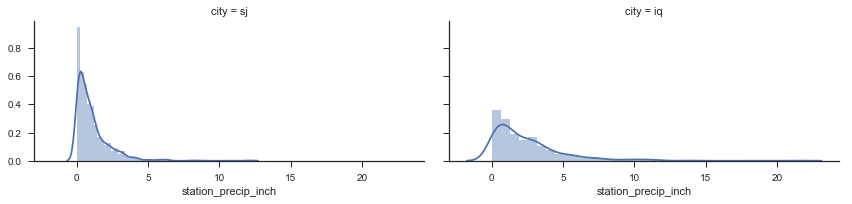

In [64]:
# Puerto Rico has much more rain then Peru but Peru seems to have a more constant amount. Interesting, it's the oppoiste of 
# the humidity graphs.
figsize = (14, 12)
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(dengue, col="city", aspect =2)
g.map(sns.distplot, "station_precip_inch")
None

In [65]:
# Imputing the missing values
print(dengue['station_avg_temp_f'].describe())

print('Mode', mode(dengue['station_avg_temp_f']))

strategy = 'median' 

statemp_imputer = Imputer(strategy=strategy)
statemp_imputer.fit(dengue[['station_avg_temp_f']])

SATFs = statemp_imputer.transform(
    dengue[['station_avg_temp_f']])
print(SATFs[0:5], SATFs.mean())
# Imputered the missing values and added them to the column.
dengue[['station_avg_temp_f']]=SATFs

count    1413.000000
mean       80.934410
std         2.326225
min        70.520000
25%        79.340000
50%        81.345714
75%        82.682857
max        87.440000
Name: station_avg_temp_f, dtype: float64
Mode ModeResult(mode=array([ 81.32]), count=array([17]))
[[ 77.79714285]
 [ 80.08571428]
 [ 80.08571428]
 [ 81.44857143]
 [ 84.09714285]] 80.9465571034


In [66]:
# Imputing the missing values
print(dengue['station_diur_temp_rng_f'].describe())

print('Mode', mode(dengue['station_diur_temp_rng_f']))

strategy = 'median' 

stadtemp_imputer = Imputer(strategy=strategy)
stadtemp_imputer.fit(dengue[['station_diur_temp_rng_f']])

SDTRFs = stadtemp_imputer.transform(
    dengue[['station_diur_temp_rng_f']])
print(SDTRFs[0:5], SDTRFs.mean())
# Imputered the missing values and added them to the column.
dengue[['station_diur_temp_rng_f']]=SDTRFs

count    1413.000000
mean       46.506790
std         3.831422
min        40.151429
25%        43.725714
50%        45.140000
75%        49.220000
max        60.440000
Name: station_diur_temp_rng_f, dtype: float64
Mode ModeResult(mode=array([ 43.13428571]), count=array([14]))
[[ 44.42      ]
 [ 43.46857143]
 [ 43.67428571]
 [ 44.18857143]
 [ 48.86857143]] 46.4664250392


In [67]:
# This column is being dropped becasue it has the same values as reanalysis_sat_precip_amt_inch. I decided to drop this column
# over the other becasue this is the only column from a single sourced data set. The other column is coming from data set with
# multiple other features which are all scaled the same. The scaling is different for the column being dropped, so it makes 
#sense to drop this column instead of the one from the group.
dengue.drop('precipitation_amt_inch', axis = 1, inplace = True)

In [68]:
# I decided to drop this column becasue its a reanalysis of a column alrady in the dataset and that column makes more sense
# then this one. They are scaled differently and this one, once converted from Kelvin to Farenheit, didn't make sense anymore
# and I was concerned it would cause more harm then good for my data set. Also, the range of tempature difference throughout the
# day shouldn't make a difference unless its a large one, as in a range of 50 or more degrees, and that rarely happens in nature.
dengue.drop('reanalysis_tdtr_f', axis =1, inplace = True)

In [69]:
dengue.head()

,city,year,weekofyear,week_start_date,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_relative_humidity_percent,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f,reanalysis_sat_precip_amt_inch,station_precip_inch,reanalysis_min_air_temp_f,reanalysis_air_temp_f,reanalysis_avg_temp_f,reanalysis_dew_point_temp_f,reanalysis_max_air_temp_f,reanalysis_precip_amt_lb_per_in2,reanalysis_specific_humidity_gr_per_lb,total_cases
0,sj,1990,18,1990-04-30,0.103725,0.198483,0.177617,73.365714,77.797143,84.92,68.00,44.420000,0.488976,0.629921,72.95,75.961143,76.267143,66.675714,79.97,0.045515,98.09,4
1,sj,1990,19,1990-05-07,0.142175,0.162357,0.155486,77.368571,80.085714,89.06,71.96,43.468571,0.898425,0.338583,73.85,77.110571,77.527143,69.442571,81.95,0.025517,107.61,5
2,sj,1990,20,1990-05-14,0.172967,0.157200,0.170843,82.052857,80.085714,89.96,73.04,43.674286,1.359843,1.629921,75.47,78.136571,78.311429,72.111714,81.23,0.037123,117.94,4
3,sj,1990,21,1990-05-21,0.245067,0.227557,0.235886,80.337143,81.448571,91.94,73.94,44.188571,0.604724,0.157480,74.93,78.506857,78.941429,71.888000,82.85,0.019770,116.71,3
4,sj,1990,22,1990-05-28,0.262200,0.251200,0.247340,80.460000,84.097143,95.00,75.02,48.868571,0.296063,0.228346,75.83,79.463429,79.725714,72.808571,83.75,0.017352,120.47,6


In [70]:
# Created a column that shows the rate in change between weeks in total cases.
#dengue['change'] = dengue.total_cases.pct_change()
dengue['change_in_cases'] = dengue['total_cases'].diff(1)
dengue = dengue.fillna(0)

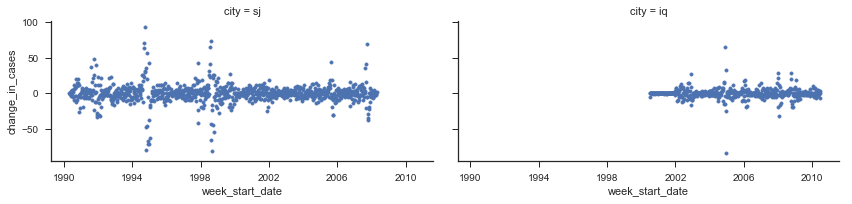

In [71]:
figsize = (25, 20)
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(dengue, col="city", aspect =2)
g.map(plt.scatter,"week_start_date", "change_in_cases", marker=".")
None

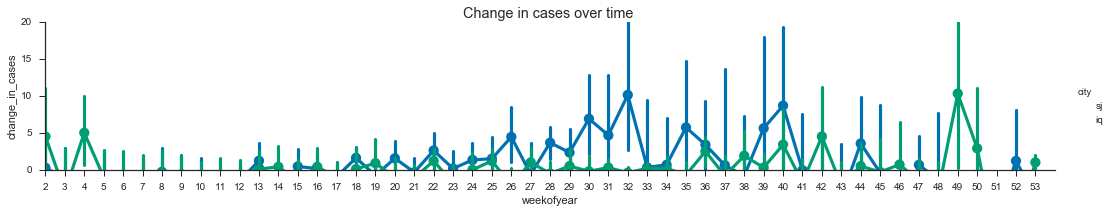

In [72]:
#
sns.set(style="ticks", palette="colorblind")
kws = dict(s=50, linewidth=.5, edgecolor="w")
fig = sns.FacetGrid(dengue, hue='city', aspect=5, hue_order=["sj", "iq"]) 
fig.map(sns.pointplot,'weekofyear','change_in_cases', **kws)
max_x = dengue.weekofyear.max()
min_x = dengue.weekofyear.min()
fig.set(xlim=(min_x,max_x))
fig.set(ylim=(0, 20))
fig.add_legend()
fig.fig.suptitle("Change in cases over time")
None

In [262]:
dengue.head(10)

,city,year,weekofyear,week_start_date,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_relative_humidity_percent,station_avg_temp_f,station_max_temp_f,station_min_temp_f,station_diur_temp_rng_f,reanalysis_sat_precip_amt_inch,station_precip_inch,reanalysis_min_air_temp_f,reanalysis_air_temp_f,reanalysis_avg_temp_f,reanalysis_dew_point_temp_f,reanalysis_max_air_temp_f,reanalysis_precip_amt_lb_per_in2,reanalysis_specific_humidity_gr_per_lb,total_cases,change_in_cases
0,sj,1990,18,1990-04-30,0.103725,0.198483,0.177617,73.365714,77.797143,84.92,68.00,44.420000,0.488976,0.629921,72.95,75.961143,76.267143,66.675714,79.97,0.045515,98.09,4,0.0
1,sj,1990,19,1990-05-07,0.142175,0.162357,0.155486,77.368571,80.085714,89.06,71.96,43.468571,0.898425,0.338583,73.85,77.110571,77.527143,69.442571,81.95,0.025517,107.61,5,1.0
2,sj,1990,20,1990-05-14,0.172967,0.157200,0.170843,82.052857,80.085714,89.96,73.04,43.674286,1.359843,1.629921,75.47,78.136571,78.311429,72.111714,81.23,0.037123,117.94,4,-1.0
3,sj,1990,21,1990-05-21,0.245067,0.227557,0.235886,80.337143,81.448571,91.94,73.94,44.188571,0.604724,0.157480,74.93,78.506857,78.941429,71.888000,82.85,0.019770,116.71,3,-1.0
4,sj,1990,22,1990-05-28,0.262200,0.251200,0.247340,80.460000,84.097143,95.00,75.02,48.868571,0.296063,0.228346,75.83,79.463429,79.725714,72.808571,83.75,0.017352,120.47,6,3.0
5,sj,1990,23,1990-06-04,0.174850,0.254314,0.181743,79.891429,82.605714,93.92,75.02,44.497143,0.377165,1.539370,76.91,79.664000,79.905714,72.862571,84.65,0.037678,120.49,2,-4.0
6,sj,1990,24,1990-06-11,0.092800,0.205071,0.210271,82.000000,81.345714,89.96,73.94,44.188571,0.137008,1.169291,76.19,78.902857,78.928571,72.888286,82.67,0.054902,120.64,4,2.0
7,sj,1990,25,1990-06-18,0.072500,0.151471,0.133029,83.375714,83.068571,93.02,73.04,45.834286,5.949606,0.830709,77.45,79.594571,79.481429,74.086571,81.41,0.042670,125.84,5,1.0
8,sj,1990,26,1990-06-25,0.146175,0.125571,0.123600,82.768571,82.991429,93.02,73.04,45.294286,0.760630,0.830709,76.19,79.571429,79.532857,73.811429,84.11,0.053352,124.53,10,5.0
9,sj,1990,27,1990-07-02,0.121550,0.160683,0.202567,81.281429,82.991429,93.02,75.92,43.725714,0.567323,0.043307,77.99,80.607714,80.831429,74.302571,84.47,0.040394,126.50,6,-4.0


## 4. Preprocessing

#### Spliting the Data set, Train_Test_Split, Scaling, and Baseline

In [73]:
# Setting up separate data sets for each city.
dengue_sj = dengue[dengue.city=='sj'].copy()
dengue_iq = dengue[dengue.city=='iq'].copy()

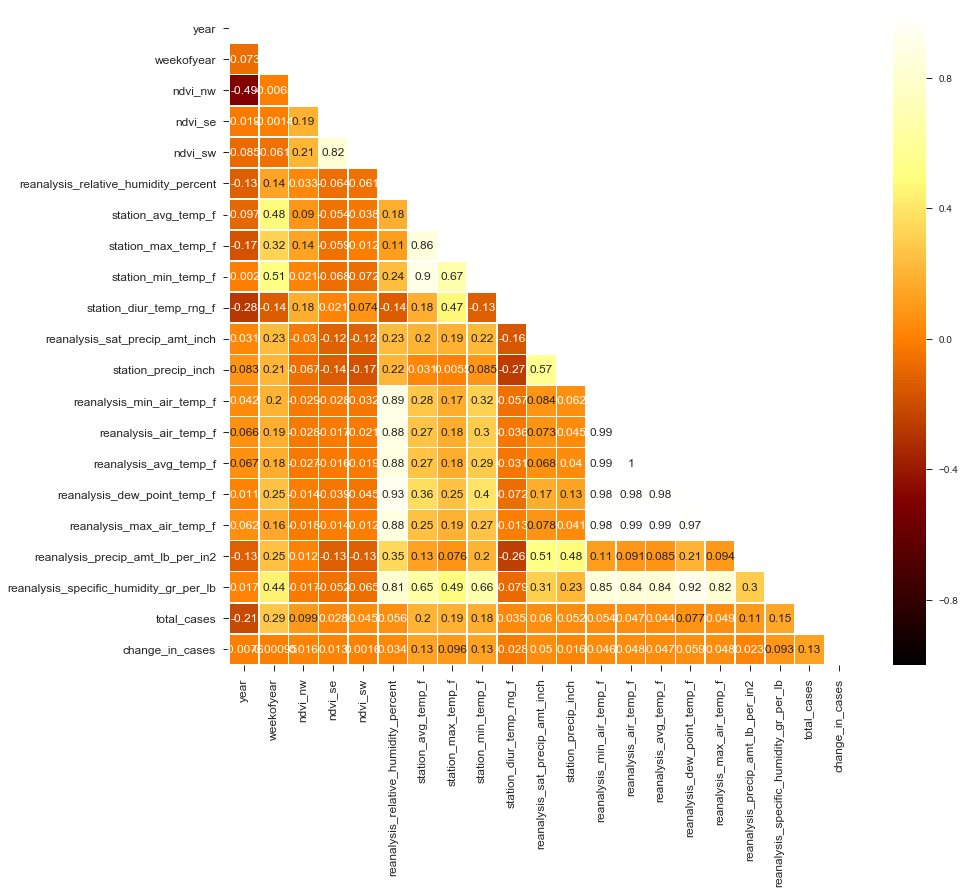

In [74]:
corr_sj = dengue_sj.corr()

fig, ax = plt.subplots(figsize=(14,12))

mask = np.zeros_like(corr_sj, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr_sj, mask=mask, ax=ax, annot=True, cmap="afmhot",  linewidths=.5)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12)

plt.show()

In [75]:
dengue_sj.corr()['total_cases'].sort_values(ascending=False)

total_cases                               1.000000
weekofyear                                0.287134
station_avg_temp_f                        0.196702
station_max_temp_f                        0.190209
station_min_temp_f                        0.176505
reanalysis_specific_humidity_gr_per_lb    0.149235
change_in_cases                           0.132566
reanalysis_precip_amt_lb_per_in2          0.106144
ndvi_nw                                   0.098656
reanalysis_dew_point_temp_f               0.077443
reanalysis_sat_precip_amt_inch            0.060258
reanalysis_relative_humidity_percent      0.055860
reanalysis_min_air_temp_f                 0.054418
station_precip_inch                       0.051596
reanalysis_max_air_temp_f                 0.049498
reanalysis_air_temp_f                     0.047159
ndvi_sw                                   0.045293
reanalysis_avg_temp_f                     0.044047
station_diur_temp_rng_f                   0.035280
ndvi_se                        

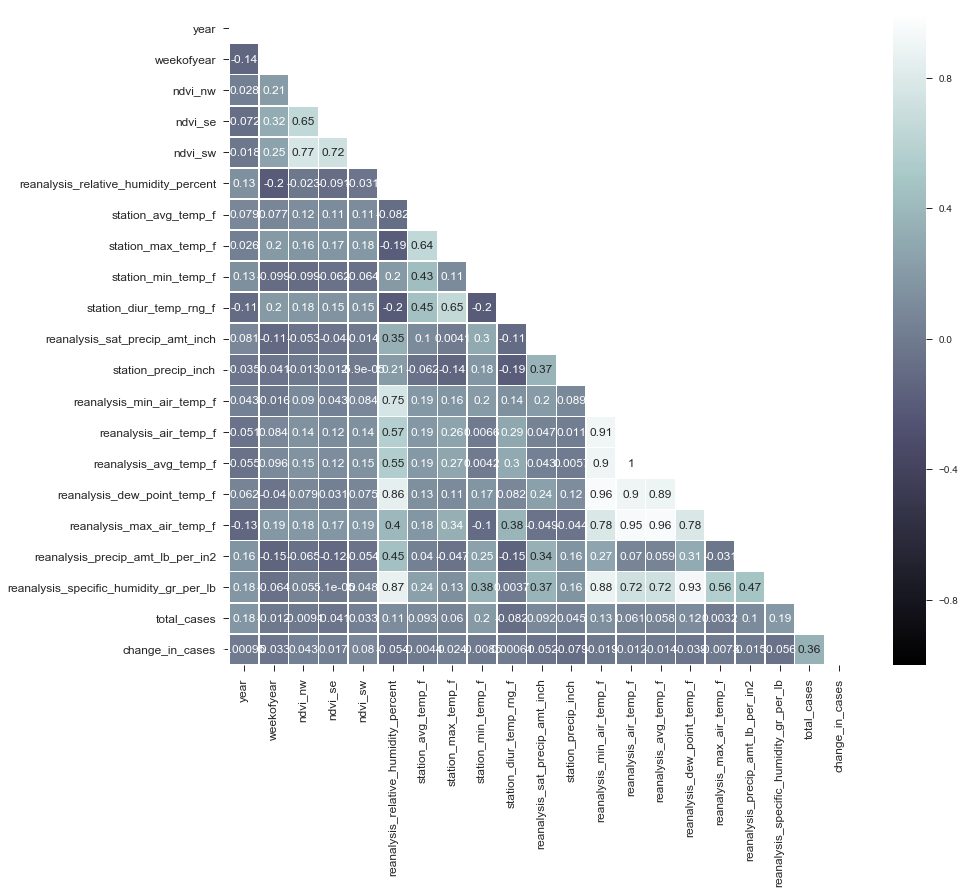

In [76]:
corr_iq = dengue_iq.corr()

fig, ax = plt.subplots(figsize=(14,12))

mask = np.zeros_like(corr_iq, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr_iq, mask=mask, ax=ax, annot=True, cmap="bone",  linewidths=.5)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12)

plt.show()

In [77]:
dengue_iq.corr()['total_cases'].sort_values(ascending=False)

total_cases                               1.000000
change_in_cases                           0.355724
station_min_temp_f                        0.198314
reanalysis_specific_humidity_gr_per_lb    0.187869
year                                      0.179451
reanalysis_min_air_temp_f                 0.126346
reanalysis_dew_point_temp_f               0.116797
reanalysis_relative_humidity_percent      0.114537
reanalysis_precip_amt_lb_per_in2          0.103897
station_avg_temp_f                        0.093437
reanalysis_sat_precip_amt_inch            0.092041
reanalysis_air_temp_f                     0.060802
station_max_temp_f                        0.060392
reanalysis_avg_temp_f                     0.057585
station_precip_inch                       0.045364
ndvi_sw                                   0.033163
reanalysis_max_air_temp_f                 0.003245
ndvi_nw                                  -0.009053
weekofyear                               -0.011850
ndvi_se                        

#### Analysis of Heatmaps for divided data sets
** Describe here**

In [78]:
# Checking shape and info for each new data set. Each set has been cleaned and though the San Juan set has more data, the data
# in both sets is complete and is ready for modeling.
print("San Juan dataset", dengue_sj.shape)
print("San Juan dataset", dengue_sj.info())
print("Iquitos dataset", dengue_iq.shape)
print("Iquitos dataset", dengue_iq.info())

San Juan dataset (936, 23)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 0 to 935
Data columns (total 23 columns):
city                                      936 non-null object
year                                      936 non-null int64
weekofyear                                936 non-null int64
week_start_date                           936 non-null datetime64[ns]
ndvi_nw                                   936 non-null float64
ndvi_se                                   936 non-null float64
ndvi_sw                                   936 non-null float64
reanalysis_relative_humidity_percent      936 non-null float64
station_avg_temp_f                        936 non-null float64
station_max_temp_f                        936 non-null float64
station_min_temp_f                        936 non-null float64
station_diur_temp_rng_f                   936 non-null float64
reanalysis_sat_precip_amt_inch            936 non-null float64
station_precip_inch                       936 n

In [79]:
# X and y values for San Juan set
Xsj = dengue_sj[['year', 'weekofyear','ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'reanalysis_relative_humidity_percent',
       'station_avg_temp_f', 'station_max_temp_f', 'station_min_temp_f',
       'station_diur_temp_rng_f', 'reanalysis_sat_precip_amt_inch',
       'station_precip_inch', 'reanalysis_min_air_temp_f',
       'reanalysis_air_temp_f', 'reanalysis_avg_temp_f',
       'reanalysis_dew_point_temp_f', 'reanalysis_max_air_temp_f',
       'reanalysis_precip_amt_lb_per_in2',
       'reanalysis_specific_humidity_gr_per_lb']]
ysj = dengue_sj.total_cases

In [80]:
# Train test split initiated for San Juan set
Xsj_train, Xsj_test, ysj_train, ysj_test = train_test_split(Xsj, ysj, random_state = 42,test_size =.50 )

In [81]:
# X and y values for Iquitos set
Xiq = dengue_iq[['year', 'weekofyear','ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'reanalysis_relative_humidity_percent',
       'station_avg_temp_f', 'station_max_temp_f', 'station_min_temp_f',
       'station_diur_temp_rng_f', 'reanalysis_sat_precip_amt_inch',
       'station_precip_inch', 'reanalysis_min_air_temp_f',
       'reanalysis_air_temp_f', 'reanalysis_avg_temp_f',
       'reanalysis_dew_point_temp_f', 'reanalysis_max_air_temp_f',
       'reanalysis_precip_amt_lb_per_in2',
       'reanalysis_specific_humidity_gr_per_lb']]
yiq = dengue_iq.total_cases

In [82]:
# Train test split initiated for Inquitos set
Xiq_train, Xiq_test, yiq_train, yiq_test = train_test_split(Xiq, yiq, random_state = 42,test_size =.50 )

In [83]:
# Scaling will be put in the pipeline so I'm not going to do it here; it will be in the next section.
# I will be using Standard Scalar

In [84]:
# Creating baseline based on MAE
# create y pred for ysj
#y_pred1 = ysj_train.mean()
#dengue["y_pred1"] = ysj_train.mean()
# create y pred for yiq
#y_pred2 = yiq_train.mean()
#dengue["y_pred2"] = yiq_train.mean()
# set up y true for ysj and yiq
#y_true1 = ysj_train
#y_true2 = yiq_train

In [85]:
# creating y pred for both citied.
y_pred1 = np.ones(len(ysj_train)) * ysj_train.mean()
y_pred2 = np.ones(len(yiq_train)) * yiq_train.mean()

y_pred = np.append(y_pred1,y_pred2)

In [86]:
y_true = np.append(ysj_train,yiq_train)

In [87]:
# Created Baseline for model
mean_absolute_error(y_true, y_pred)

20.000084530853762

#### Summary of Observations and Next Steps

## 5. Modeling

### 5. a. Regression Model 
Gradient Boosting Regression and SVR for San Juan data set

In [273]:
# Setting up pipeline for gradient boosting regression model
gbr = GradientBoostingRegressor(learning_rate = 0.1,
                                random_state = 42)
# Setting up pipe
pipe = Pipeline([("scaler", StandardScaler()), ("gbr", gbr)])

# fit model
gbr_cv = GridSearchCV(pipe,
                      dict(gbr__n_estimators = [50, 100, 150],
                           gbr__max_depth = [6, 8, 10, 12]),
                      cv = 7,
                      scoring = make_scorer(mean_absolute_error),
                      verbose = 100)
gbr_cv.fit(Xsj_train, ysj_train)

Fitting 7 folds for each of 12 candidates, totalling 84 fits
[CV] gbr__max_depth=6, gbr__n_estimators=50 ..........................
[CV]  gbr__max_depth=6, gbr__n_estimators=50, score=20.29853390362777, total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] gbr__max_depth=6, gbr__n_estimators=50 ..........................
[CV]  gbr__max_depth=6, gbr__n_estimators=50, score=16.832710970571604, total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[CV] gbr__max_depth=6, gbr__n_estimators=50 ..........................
[CV]  gbr__max_depth=6, gbr__n_estimators=50, score=12.958559201865395, total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[CV] gbr__max_depth=6, gbr__n_estimators=50 ..........................
[CV]  gbr__max_depth=6, gbr__n_estimators=50, score=21.61215293872976, total=   0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:  

[CV]  gbr__max_depth=8, gbr__n_estimators=100, score=14.780701413559257, total=   0.2s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    6.2s remaining:    0.0s
[CV] gbr__max_depth=8, gbr__n_estimators=150 .........................
[CV]  gbr__max_depth=8, gbr__n_estimators=150, score=20.443873113376235, total=   0.3s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    6.6s remaining:    0.0s
[CV] gbr__max_depth=8, gbr__n_estimators=150 .........................
[CV]  gbr__max_depth=8, gbr__n_estimators=150, score=22.11531952483173, total=   0.3s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    7.0s remaining:    0.0s
[CV] gbr__max_depth=8, gbr__n_estimators=150 .........................
[CV]  gbr__max_depth=8, gbr__n_estimators=150, score=13.21844178080695, total=   0.2s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    7.3s remaining:    0.0s
[CV] gbr__max_depth=8, gbr__n_estimators=150 .........................
[CV]  gbr__max_depth=8, gbr__n_estimators=150, sco

[CV]  gbr__max_depth=12, gbr__n_estimators=50, score=18.48608924393274, total=   0.1s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   18.2s remaining:    0.0s
[CV] gbr__max_depth=12, gbr__n_estimators=100 ........................
[CV]  gbr__max_depth=12, gbr__n_estimators=100, score=19.23060424668111, total=   0.4s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:   18.7s remaining:    0.0s
[CV] gbr__max_depth=12, gbr__n_estimators=100 ........................
[CV]  gbr__max_depth=12, gbr__n_estimators=100, score=23.074352877960223, total=   0.3s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   19.2s remaining:    0.0s
[CV] gbr__max_depth=12, gbr__n_estimators=100 ........................
[CV]  gbr__max_depth=12, gbr__n_estimators=100, score=15.53991645821019, total=   0.3s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:   19.6s remaining:    0.0s
[CV] gbr__max_depth=12, gbr__n_estimators=100 ........................
[CV]  gbr__max_depth=12, gbr__n_estimators=100, 

GridSearchCV(cv=7, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbr', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
     ...ors=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gbr__n_estimators': [50, 100, 150], 'gbr__max_depth': [6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error), verbose=100)

In [274]:
print("Best score",gbr_cv.best_score_)

print("Best params",gbr_cv.best_params_)

print("Test score",gbr_cv.score(Xsj_test, ysj_test))

gbrcv_pred = gbr_cv.predict(Xsj_test)

Best score 19.3506499365
Best params {'gbr__max_depth': 12, 'gbr__n_estimators': 150}
Test score 19.0487985594


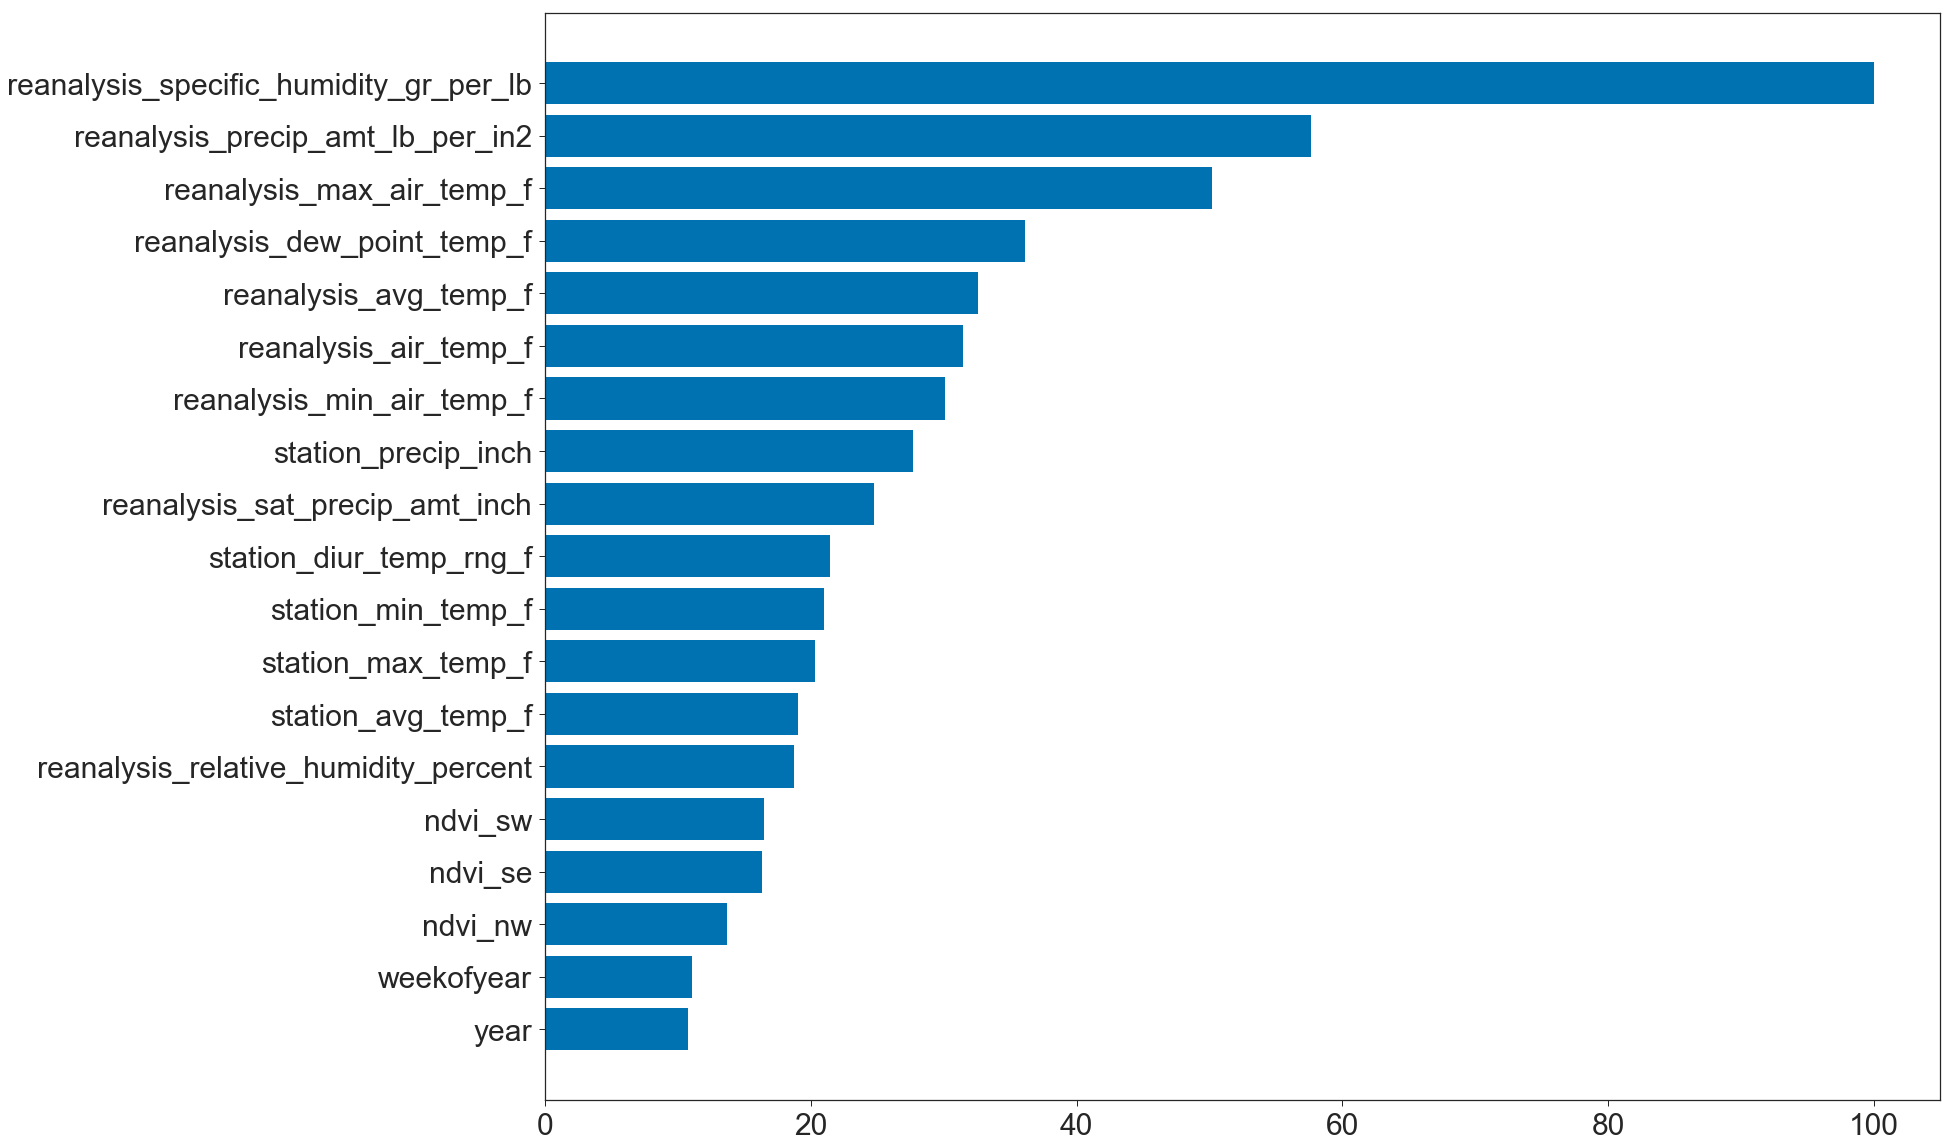

In [228]:
fig, ax = plt.subplots(figsize=(25,20))
gbr.fit(Xsj_train, ysj_train)
feature_importance = gbr.feature_importances_
feature_importance = 100 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx])
plt.yticks(pos, Xsj_train.columns)
ax.tick_params(labelsize=30);

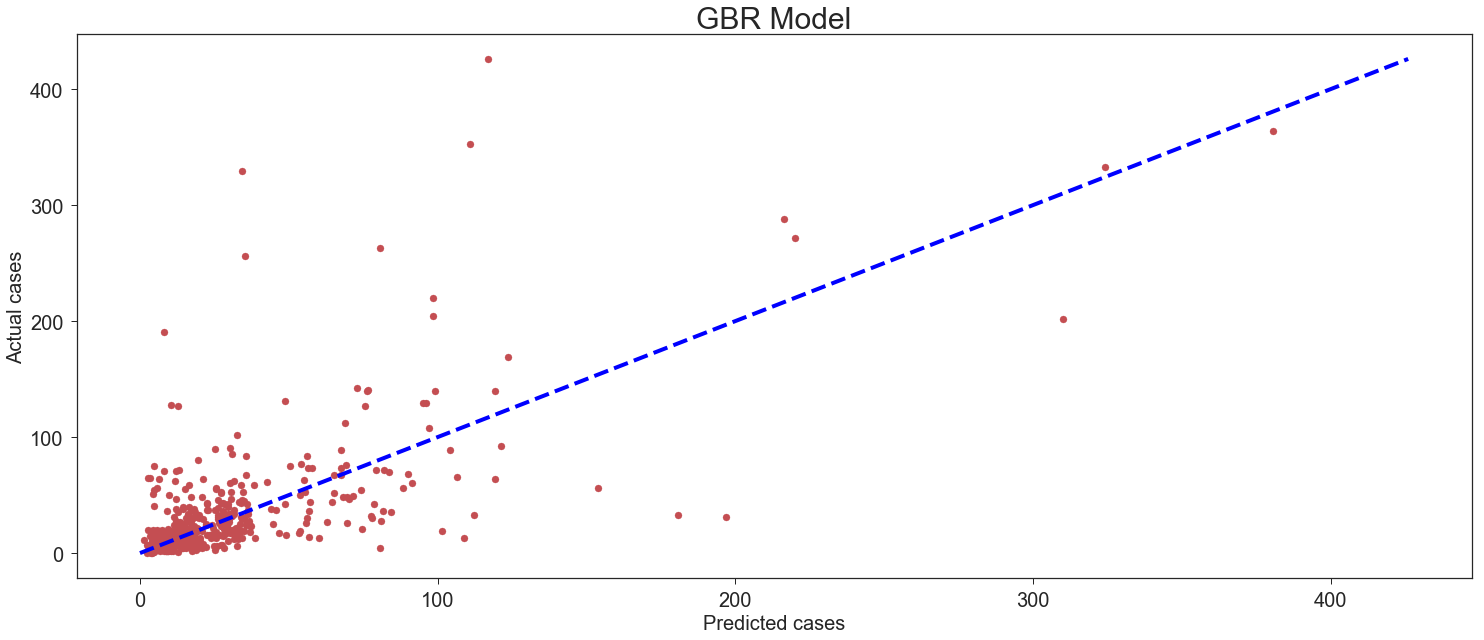

In [275]:
fig, ax = plt.subplots(figsize=(25, 10))
actual_values = ysj_test
plt.scatter(gbrcv_pred, actual_values, color='r')
ax.plot([ysj_test.min(), ysj_test.max()], [ysj_test.min(), ysj_test.max()], 'k--', lw=4, color = 'blue')
plt.xlabel('Predicted cases', fontsize=20)
plt.ylabel('Actual cases', fontsize=20)
plt.title('GBR Model', fontsize=30)
ax.tick_params(labelsize=20);

In [222]:
# Setting up pipeline for SVR
svr = SVR(kernel='linear')

# Setting up pipe
pipe = Pipeline([("scaler", StandardScaler()), ("svr", svr)])

# fit model
svr_cv = GridSearchCV(pipe,
                      dict(svr__gamma = [5, 15, 30],
                           svr__C = [5, 15, 30]),
                      cv = 7,
                      scoring = make_scorer(mean_absolute_error),
                      verbose = 100)
svr_cv.fit(Xsj_train, ysj_train)

Fitting 7 folds for each of 9 candidates, totalling 63 fits
[CV] svr__C=5, svr__gamma=5 ..........................................
[CV] . svr__C=5, svr__gamma=5, score=29.539265988910742, total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] svr__C=5, svr__gamma=5 ..........................................
[CV] .. svr__C=5, svr__gamma=5, score=20.63672769753053, total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] svr__C=5, svr__gamma=5 ..........................................
[CV] . svr__C=5, svr__gamma=5, score=19.729938079582073, total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[CV] svr__C=5, svr__gamma=5 ..........................................
[CV] . svr__C=5, svr__gamma=5, score=28.712485993135466, total=   0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[CV] svr__C=5, svr__gamma=5 ........................

[CV]  svr__C=15, svr__gamma=30, score=28.66166158146973, total=   0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    1.3s remaining:    0.0s
[CV] svr__C=15, svr__gamma=30 ........................................
[CV]  svr__C=15, svr__gamma=30, score=23.510089987051586, total=   0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.3s remaining:    0.0s
[CV] svr__C=15, svr__gamma=30 ........................................
[CV]  svr__C=15, svr__gamma=30, score=15.952464114304322, total=   0.0s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:    1.4s remaining:    0.0s
[CV] svr__C=15, svr__gamma=30 ........................................
[CV]  svr__C=15, svr__gamma=30, score=16.26137456732871, total=   0.0s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    1.4s remaining:    0.0s
[CV] svr__C=30, svr__gamma=5 .........................................
[CV]  svr__C=30, svr__gamma=5, score=29.632634310749438, total=   0.0s
[Parallel(n_jobs=1)]: Done  43 out of  

GridSearchCV(cv=7, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'svr__gamma': [5, 15, 30], 'svr__C': [5, 15, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error), verbose=100)

In [223]:
print("Best score",svr_cv.best_score_)

print("Best params",svr_cv.best_params_)

print("Test score",svr_cv.score(Xsj_test, ysj_test))

svrcv_pred = svr_cv.predict(Xsj_test)

Best score 22.1321645867
Best params {'svr__C': 30, 'svr__gamma': 5}
Test score 22.8613167148


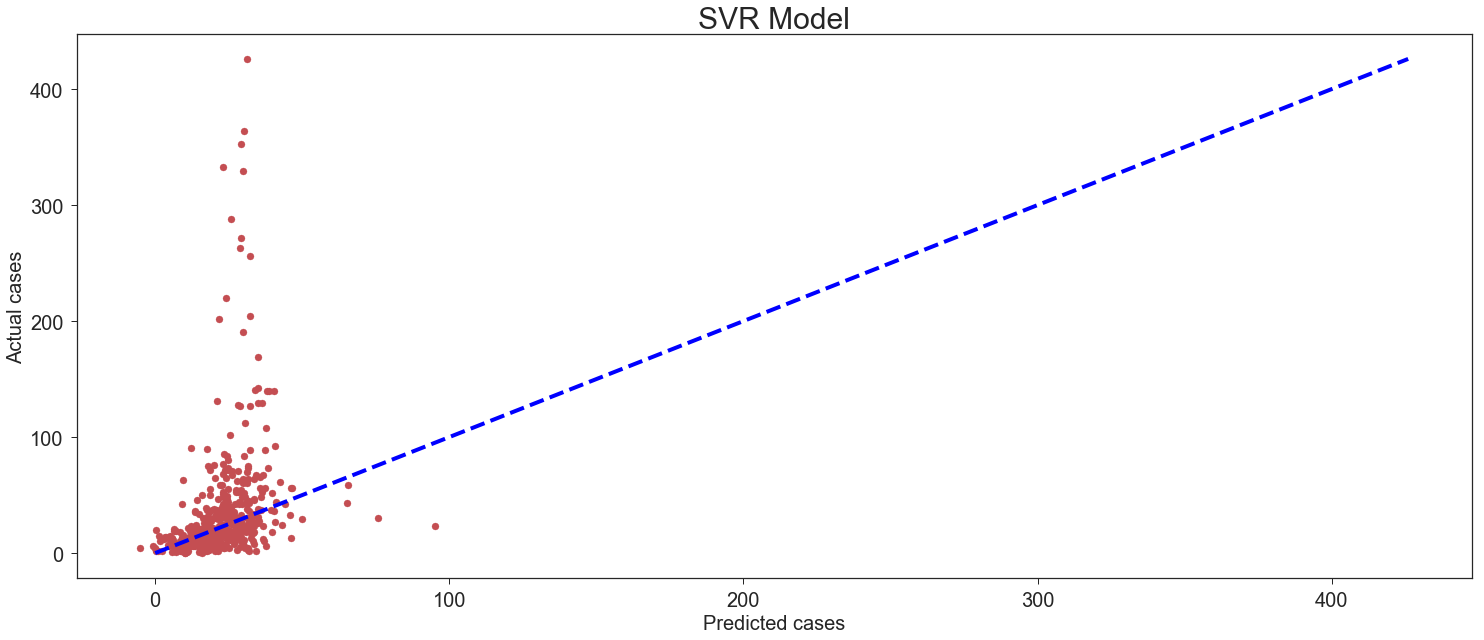

In [224]:
fig, ax = plt.subplots(figsize=(25, 10))
actual_values = ysj_test
plt.scatter(svrcv_pred, actual_values, color='r')
ax.plot([ysj_test.min(), ysj_test.max()], [ysj_test.min(), ysj_test.max()], 'k--', lw=4, color = 'blue')
plt.xlabel('Predicted cases', fontsize=20)
plt.ylabel('Actual cases', fontsize=20)
plt.title('SVR Model', fontsize=30)
ax.tick_params(labelsize=20);

### 5. b. Regression Model 
Gradient Boosting Regression and SVR for Iquito data set

In [278]:
# Setting up pipeline for gradient boosting regression model
gbr = GradientBoostingRegressor(learning_rate = 0.1,
                                random_state = 42)
# Setting up pipe
pipe = Pipeline([("scaler", StandardScaler()), ("gbr", gbr)])

# fit model
gbr_cv = GridSearchCV(pipe,
                      dict(gbr__n_estimators = [150, 200, 250],
                           gbr__max_depth = [6, 8, 10, 12]),
                      cv = 7,
                      scoring = make_scorer(mean_absolute_error),
                      verbose = 100)
gbr_cv.fit(Xiq_train, yiq_train)

Fitting 7 folds for each of 12 candidates, totalling 84 fits
[CV] gbr__max_depth=6, gbr__n_estimators=150 .........................
[CV]  gbr__max_depth=6, gbr__n_estimators=150, score=5.2074798790985, total=   0.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[CV] gbr__max_depth=6, gbr__n_estimators=150 .........................
[CV]  gbr__max_depth=6, gbr__n_estimators=150, score=5.08449204093877, total=   0.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[CV] gbr__max_depth=6, gbr__n_estimators=150 .........................
[CV]  gbr__max_depth=6, gbr__n_estimators=150, score=5.857688453684874, total=   0.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[CV] gbr__max_depth=6, gbr__n_estimators=150 .........................
[CV]  gbr__max_depth=6, gbr__n_estimators=150, score=6.235135409643397, total=   0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:   

[CV]  gbr__max_depth=8, gbr__n_estimators=250, score=6.478936586068014, total=   0.1s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    7.4s remaining:    0.0s
[CV] gbr__max_depth=8, gbr__n_estimators=250 .........................
[CV]  gbr__max_depth=8, gbr__n_estimators=250, score=6.006731449761207, total=   0.1s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    7.6s remaining:    0.0s
[CV] gbr__max_depth=8, gbr__n_estimators=250 .........................
[CV]  gbr__max_depth=8, gbr__n_estimators=250, score=5.3893611483231005, total=   0.2s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    7.9s remaining:    0.0s
[CV] gbr__max_depth=8, gbr__n_estimators=250 .........................
[CV]  gbr__max_depth=8, gbr__n_estimators=250, score=7.460875266533842, total=   0.1s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    8.1s remaining:    0.0s
[CV] gbr__max_depth=8, gbr__n_estimators=250 .........................
[CV]  gbr__max_depth=8, gbr__n_estimators=250, scor

[CV]  gbr__max_depth=12, gbr__n_estimators=200, score=6.569985833513961, total=   0.1s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:   14.5s remaining:    0.0s
[CV] gbr__max_depth=12, gbr__n_estimators=200 ........................
[CV]  gbr__max_depth=12, gbr__n_estimators=200, score=6.720613402155663, total=   0.1s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   14.7s remaining:    0.0s
[CV] gbr__max_depth=12, gbr__n_estimators=200 ........................
[CV]  gbr__max_depth=12, gbr__n_estimators=200, score=6.9442610844646335, total=   0.1s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:   14.9s remaining:    0.0s
[CV] gbr__max_depth=12, gbr__n_estimators=200 ........................
[CV]  gbr__max_depth=12, gbr__n_estimators=200, score=8.460536819220701, total=   0.1s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:   15.1s remaining:    0.0s
[CV] gbr__max_depth=12, gbr__n_estimators=200 ........................
[CV]  gbr__max_depth=12, gbr__n_estimators=200,

GridSearchCV(cv=7, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gbr', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
     ...ors=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gbr__n_estimators': [150, 200, 250], 'gbr__max_depth': [6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error), verbose=100)

In [279]:
print("Best score",gbr_cv.best_score_)

print("Best params",gbr_cv.best_params_)

print("Test score",gbr_cv.score(Xiq_test, yiq_test))

gbrcv_pred = gbr_cv.predict(Xiq_test)

Best score 6.64972105318
Best params {'gbr__max_depth': 12, 'gbr__n_estimators': 150}
Test score 6.00836697195


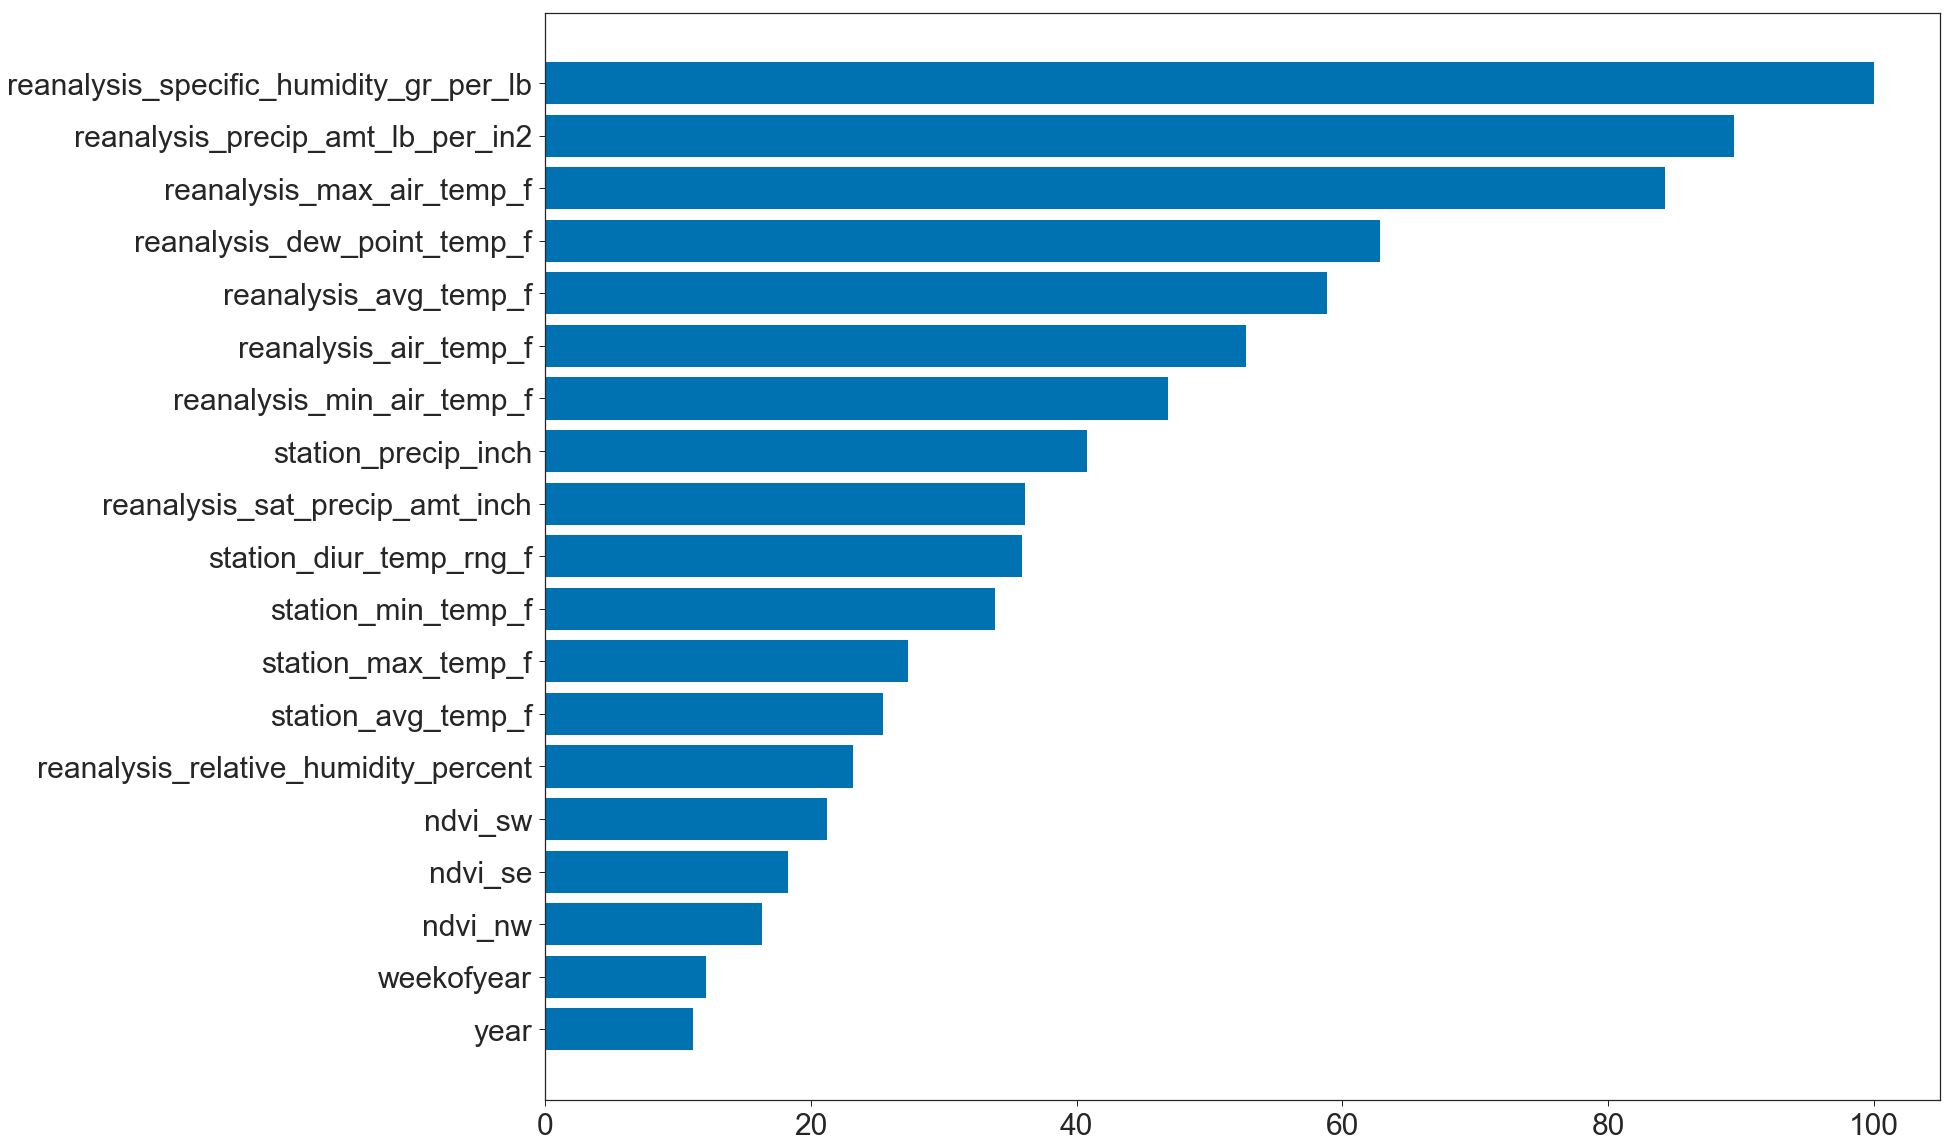

In [236]:
fig, ax = plt.subplots(figsize=(25,20))
gbr.fit(Xiq_train, yiq_train)
feature_importance = gbr.feature_importances_
feature_importance = 100 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx])
plt.yticks(pos, Xiq_train.columns)
ax.tick_params(labelsize=30);

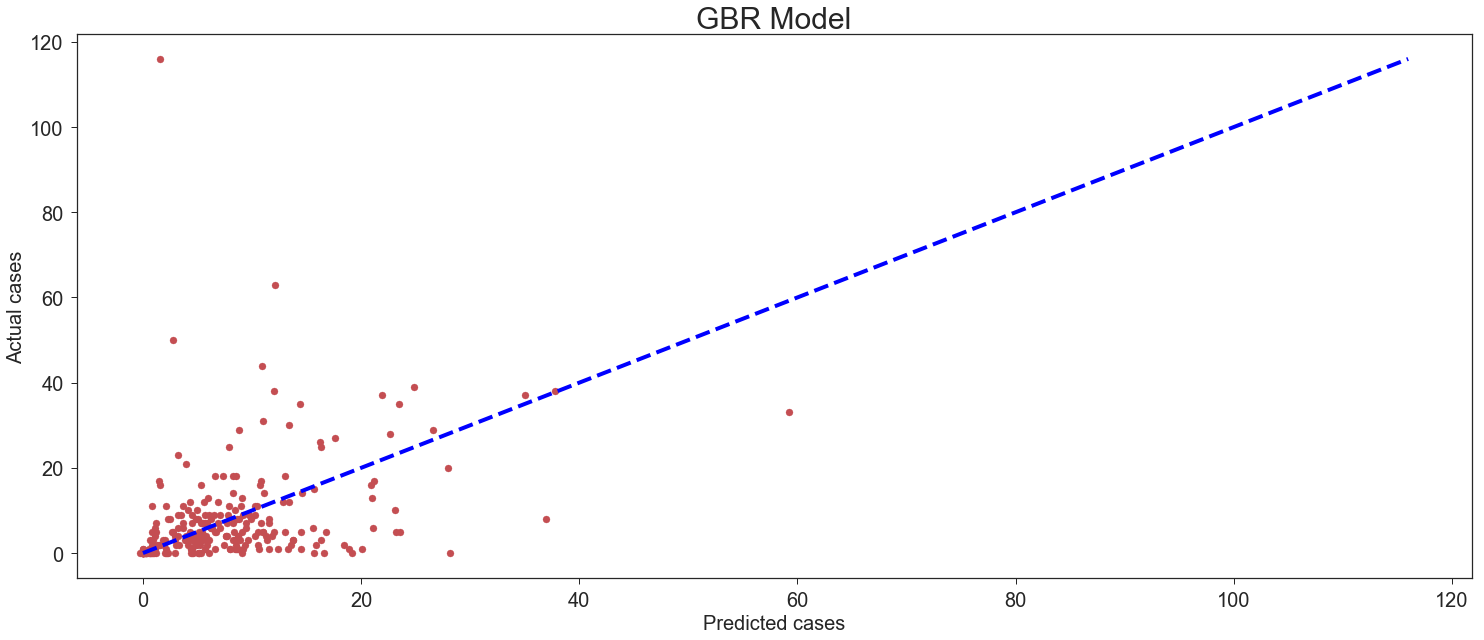

In [280]:
fig, ax = plt.subplots(figsize=(25, 10))
actual_values = yiq_test
plt.scatter(gbrcv_pred, actual_values, color='r')
ax.plot([yiq_test.min(), yiq_test.max()], [yiq_test.min(), yiq_test.max()], 'k--', lw=4, color = 'blue')
plt.xlabel('Predicted cases', fontsize=20)
plt.ylabel('Actual cases', fontsize=20)
plt.title('GBR Model', fontsize=30)
ax.tick_params(labelsize=20);

In [225]:
# Setting up pipeline for SVR
svr = SVR(kernel='linear')

# Setting up pipe
pipe = Pipeline([("scaler", StandardScaler()), ("svr", svr)])

# fit model
svr_cv = GridSearchCV(pipe,
                      dict(svr__gamma = [5, 15, 30],
                           svr__C = [5, 15, 30]),
                      cv = 7,
                      scoring = make_scorer(mean_absolute_error),
                      verbose = 100)
svr_cv.fit(Xiq_train, yiq_train)

Fitting 7 folds for each of 9 candidates, totalling 63 fits
[CV] svr__C=5, svr__gamma=5 ..........................................
[CV] .. svr__C=5, svr__gamma=5, score=5.460187492469796, total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] svr__C=5, svr__gamma=5 ..........................................
[CV] .. svr__C=5, svr__gamma=5, score=6.622804702966406, total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] svr__C=5, svr__gamma=5 ..........................................
[CV] . svr__C=5, svr__gamma=5, score=5.6067215238641195, total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[CV] svr__C=5, svr__gamma=5 ..........................................
[CV] .. svr__C=5, svr__gamma=5, score=8.081830560105793, total=   0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[CV] svr__C=5, svr__gamma=5 ........................

[CV] . svr__C=15, svr__gamma=30, score=5.59343204687663, total=   0.0s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    1.2s remaining:    0.0s
[CV] svr__C=15, svr__gamma=30 ........................................
[CV]  svr__C=15, svr__gamma=30, score=12.042040321134797, total=   0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    1.3s remaining:    0.0s
[CV] svr__C=15, svr__gamma=30 ........................................
[CV]  svr__C=15, svr__gamma=30, score=4.420527368945974, total=   0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.4s remaining:    0.0s
[CV] svr__C=15, svr__gamma=30 ........................................
[CV]  svr__C=15, svr__gamma=30, score=4.541322738730585, total=   0.0s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:    1.4s remaining:    0.0s
[CV] svr__C=15, svr__gamma=30 ........................................
[CV]  svr__C=15, svr__gamma=30, score=4.470640975251951, total=   0.0s
[Parallel(n_jobs=1)]: Done  42 out of  4

GridSearchCV(cv=7, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'svr__gamma': [5, 15, 30], 'svr__C': [5, 15, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error), verbose=100)

In [226]:
print("Best score",svr_cv.best_score_)

print("Best params",svr_cv.best_params_)

print("Test score",svr_cv.score(Xiq_test, yiq_test))

svrcv_pred = svr_cv.predict(Xiq_test)

Best score 6.33882011125
Best params {'svr__C': 30, 'svr__gamma': 5}
Test score 5.97087058154


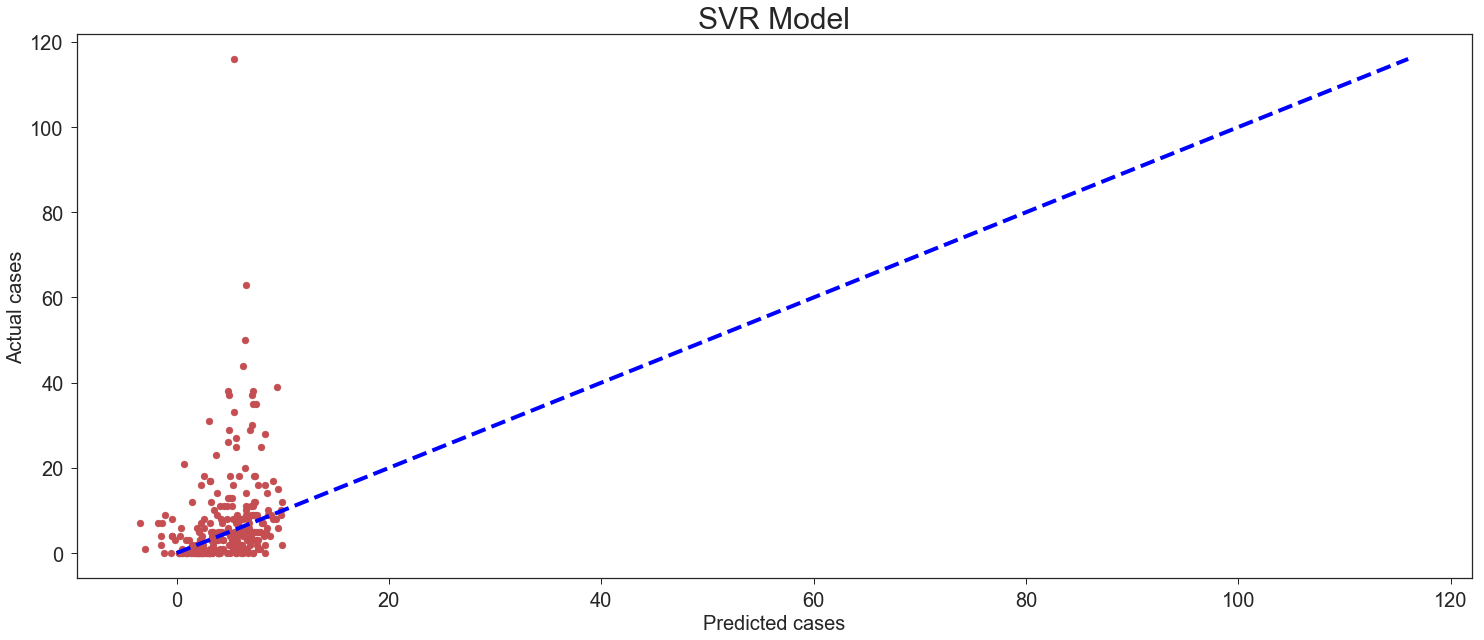

In [227]:
fig, ax = plt.subplots(figsize=(25, 10))
actual_values = yiq_test
plt.scatter(svrcv_pred, actual_values, color='r')
ax.plot([yiq_test.min(), yiq_test.max()], [yiq_test.min(), yiq_test.max()], 'k--', lw=4, color = 'blue')
plt.xlabel('Predicted cases', fontsize=20)
plt.ylabel('Actual cases', fontsize=20)
plt.title('SVR Model', fontsize=30)
ax.tick_params(labelsize=20);

#### Summary of Results
<h4> The San Juan set is larger then the Iquito set so the results differ greatly but proportionally they seem equal. The San Juan set does better with Gradient Boosting Regression while the Iquito set does better with the SVR but not by much. I would probably go with the results for the Gradient Boosting Model. I do think I need play around with some of my feature selections. Maybe if I go back and look at what has better correlations to total cases that might help.</h4>
<h4> *Update* I dropped one feature from the data set and played around with the grid search settings and got the scores down more. I'm not sure what else I can do. I can take another look at the correlation results and see if there are other features to drop but at this point I think it might be better to go through the test data set and get it ready for modeling and then run the results and see what the difference is. </h4>
<h4> *Update* I had to drop the column I feature engineered because that column couldn't be part of the test data set since it used a column that doesn't exist in the test set. Dropping that column from the data sets made a vast difference in scores. Gradient Boosting Regression is still better for the San Juan set and SVR is still better for the Iquito set but the scores have dropped so the MAE is I calculated for baseline is higher or just about the same for two best models which is great since before I was way above the baseline which wasn't good. Since the baseline is MAE we want it to be a lower number which it is but that depends on the model used.</h4>
<h4> MAE is a 'negatively-oriented score, which means lower values are better... https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d' It's the same idea behind MSE or RMSE, the lower the value the better because that means the error value is less and our reults are closer to the actual values.</h4>

### 5. b. Timeseries Model

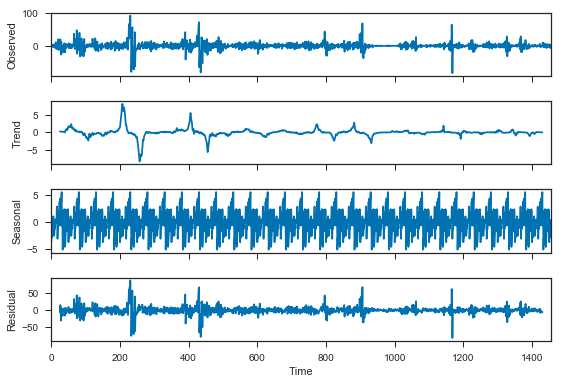

In [96]:
#decompose= sm.tsa.seasonal_decompose(dengue['week_start_date'])
#dengue.reset_index(inplace=True)
#dengue['week_start_date'] = pd.to_datetime(dengue['week_start_date'])
#dengue_ts = dengue.set_index('week_start_date')
change_in_cases_series = pd.Series(dengue['change_in_cases'])
decomposed = sm.tsa.seasonal_decompose(change_in_cases_series.values, model='additive', freq = 50)
#s=sm.tsa.seasonal_decompose(dengue.change_in_cases)
decomposed.plot()
pyplot.show()

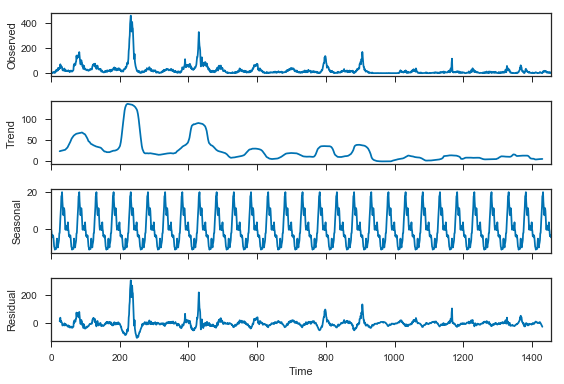

In [97]:
total_cases_series = pd.Series(dengue['total_cases'])
decomposed = sm.tsa.seasonal_decompose(total_cases_series.values, model='additive', freq = 50)
#s=sm.tsa.seasonal_decompose(dengue.change_in_cases)
decomposed.plot()
pyplot.show()

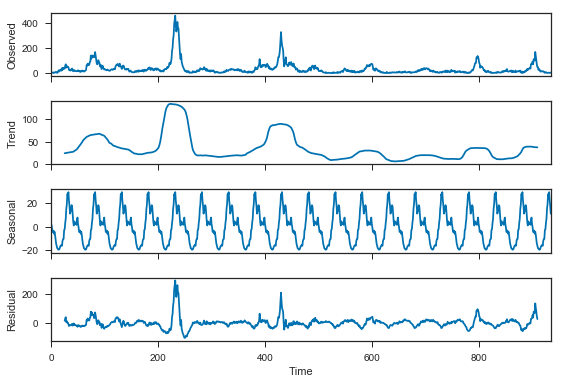

In [98]:
total_cases_series = pd.Series(dengue_sj['total_cases'])
decomposed = sm.tsa.seasonal_decompose(total_cases_series.values, model='additive', freq = 50)
decomposed.plot()
pyplot.show()

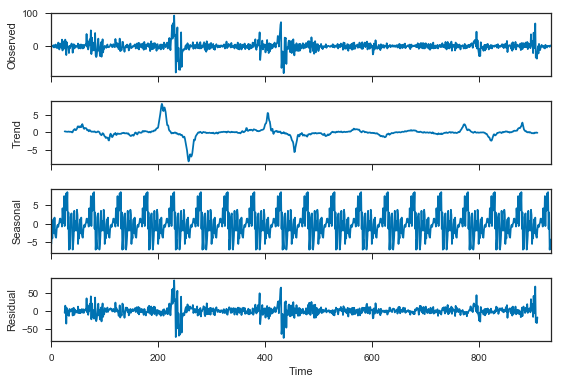

In [99]:
change_in_cases_series = pd.Series(dengue_sj['change_in_cases'])
decomposed = sm.tsa.seasonal_decompose(change_in_cases_series.values, model='additive', freq = 50)
decomposed.plot()
pyplot.show()

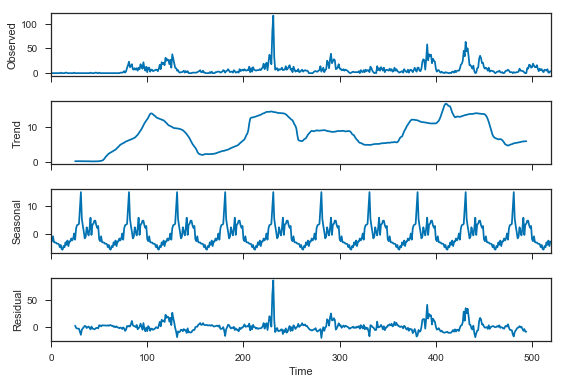

In [100]:
total_cases_series = pd.Series(dengue_iq['total_cases'])
decomposed = sm.tsa.seasonal_decompose(total_cases_series.values, model='additive', freq = 50)
decomposed.plot()
pyplot.show()

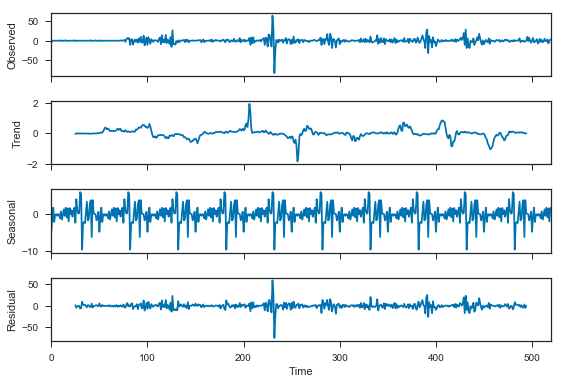

In [101]:
change_in_cases_series = pd.Series(dengue_iq['change_in_cases'])
decomposed = sm.tsa.seasonal_decompose(change_in_cases_series.values, model='additive', freq = 50)
decomposed.plot()
pyplot.show()

#### Summary of Results

## 6. Test Data set

In [102]:
#Loaded dengue test csv files
dengue_test = pd.read_csv('dengue_features_test.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [103]:
dengue_test.isnull().sum()

city                                      0
year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                  43
ndvi_nw                                  11
ndvi_se                                   1
ndvi_sw                                   1
precipitation_amt_mm                      2
reanalysis_air_temp_k                     2
reanalysis_avg_temp_k                     2
reanalysis_dew_point_temp_k               2
reanalysis_max_air_temp_k                 2
reanalysis_min_air_temp_k                 2
reanalysis_precip_amt_kg_per_m2           2
reanalysis_relative_humidity_percent      2
reanalysis_sat_precip_amt_mm              2
reanalysis_specific_humidity_g_per_kg     2
reanalysis_tdtr_k                         2
station_avg_temp_c                       12
station_diur_temp_rng_c                  12
station_max_temp_c                        3
station_min_temp_c              

In [104]:
dengue_test.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,416.000000,416.000000,373.000000,405.000000,415.000000,415.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,404.000000,404.000000,413.000000,407.000000,411.000000
mean,2010.766827,26.439904,0.126050,0.126803,0.207702,0.201721,38.354324,298.818295,299.353071,295.419179,303.623430,295.743478,42.171135,82.499810,38.354324,16.927088,5.124569,27.369587,7.810991,32.534625,22.368550,34.278589
std,1.434835,14.978257,0.164353,0.141420,0.079102,0.092028,35.171126,1.469501,1.306233,1.523099,3.101817,2.761109,48.909514,7.378243,35.171126,1.557868,3.542870,1.232608,2.449718,1.920429,1.731437,34.655966
min,2008.000000,1.000000,-0.463400,-0.211800,0.006200,-0.014671,0.000000,294.554286,295.235714,290.818571,298.200000,286.200000,0.000000,64.920000,0.000000,12.537143,1.485714,24.157143,4.042857,27.200000,14.200000,0.000000
25%,2010.000000,13.750000,-0.001500,0.015975,0.148670,0.134079,8.175000,297.751429,298.323214,294.335714,301.425000,293.500000,9.430000,77.397143,8.175000,15.792857,2.446429,26.514286,5.928571,31.100000,21.200000,9.100000
50%,2011.000000,26.000000,0.110100,0.088700,0.204171,0.186471,31.455000,298.547143,299.328571,295.825000,302.750000,296.300000,25.850000,80.330000,31.455000,17.337143,2.914286,27.483333,6.642857,32.800000,22.200000,23.600000
75%,2012.000000,39.000000,0.263329,0.242400,0.254871,0.253243,57.772500,300.240357,300.521429,296.643571,305.800000,298.275000,56.475000,88.328929,57.772500,18.174643,8.171429,28.319048,9.812500,33.900000,23.300000,47.750000
max,2013.000000,53.000000,0.500400,0.649000,0.453043,0.529043,169.340000,301.935714,303.328571,297.794286,314.100000,299.700000,301.400000,97.982857,169.340000,19.598571,14.485714,30.271429,14.725000,38.400000,26.700000,212.000000


In [105]:
dengue_test.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

##### Feature Engineering

In [106]:
dengue_test['station_avg_temp_f'] = celsius_to_fahren(dengue_test.station_avg_temp_c)
dengue_test.drop(['station_avg_temp_c'], axis = 1, inplace=True)

In [107]:
dengue_test['reanalysis_air_temp_f'] = kelvin_to_fahren(dengue_test.reanalysis_air_temp_k)
dengue_test.drop(['reanalysis_air_temp_k'], axis = 1, inplace = True)

In [108]:
dengue_test['station_min_temp_f'] = celsius_to_fahren(dengue_test.station_min_temp_c)
dengue_test.drop(['station_min_temp_c'], axis = 1, inplace=True)

In [109]:
dengue_test['station_diur_temp_rng_f'] = celsius_to_fahren(dengue_test.station_diur_temp_rng_c)
dengue_test.drop(['station_diur_temp_rng_c'], axis = 1, inplace=True)

In [110]:
dengue_test['precipitation_amt_inch'] = mm_to_inch(dengue_test.precipitation_amt_mm)
dengue_test.drop(['precipitation_amt_mm'], axis = 1, inplace = True)

In [111]:
dengue_test['reanalysis_sat_precip_amt_inch'] = mm_to_inch(dengue_test.reanalysis_sat_precip_amt_mm)
dengue_test.drop(['reanalysis_sat_precip_amt_mm'], axis = 1, inplace = True)

In [112]:
dengue_test['station_precip_inch'] = mm_to_inch(dengue_test.station_precip_mm)
dengue_test.drop(['station_precip_mm'], axis = 1, inplace = True)

In [113]:
dengue_test['reanalysis_min_air_temp_f'] = kelvin_to_fahren(dengue_test.reanalysis_min_air_temp_k)
dengue_test.drop(['reanalysis_min_air_temp_k'], axis = 1, inplace = True)

In [114]:
dengue_test['station_max_temp_f'] = celsius_to_fahren(dengue_test.station_max_temp_c)
dengue_test.drop(['station_max_temp_c'], axis = 1, inplace=True)

In [115]:
dengue_test['reanalysis_avg_temp_f'] = kelvin_to_fahren(dengue_test.reanalysis_avg_temp_k)
dengue_test.drop(['reanalysis_avg_temp_k'], axis = 1, inplace = True)

In [116]:
dengue_test['reanalysis_dew_point_temp_f'] = kelvin_to_fahren(dengue_test.reanalysis_dew_point_temp_k)
dengue_test.drop(['reanalysis_dew_point_temp_k'], axis = 1, inplace = True)

In [117]:
dengue_test['reanalysis_max_air_temp_f'] = kelvin_to_fahren(dengue_test.reanalysis_max_air_temp_k)
dengue_test.drop(['reanalysis_max_air_temp_k'], axis = 1, inplace = True)

In [118]:
dengue_test['reanalysis_tdtr_f'] = kelvin_to_fahren(dengue_test.reanalysis_tdtr_k)
dengue_test.drop(['reanalysis_tdtr_k'], axis = 1, inplace = True)

In [119]:
dengue_test['week_start_date']=pd.to_datetime(dengue_test.week_start_date)

In [120]:
dengue_test['reanalysis_precip_amt_lb_per_in2'] = kgm2_to_lbin2(dengue_test.reanalysis_precip_amt_kg_per_m2)
dengue_test.drop(['reanalysis_precip_amt_kg_per_m2'], axis = 1, inplace = True)

In [121]:
dengue_test['reanalysis_specific_humidity_gr_per_lb'] = gperkg_to_grperlb(dengue_test.reanalysis_specific_humidity_g_per_kg)
dengue_test.drop(['reanalysis_specific_humidity_g_per_kg'], axis = 1, inplace = True)

In [122]:
dengue_test.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_relative_humidity_percent,station_avg_temp_f,reanalysis_air_temp_f,station_min_temp_f,station_diur_temp_rng_f,precipitation_amt_inch,reanalysis_sat_precip_amt_inch,station_precip_inch,reanalysis_min_air_temp_f,station_max_temp_f,reanalysis_avg_temp_f,reanalysis_dew_point_temp_f,reanalysis_max_air_temp_f,reanalysis_tdtr_f,reanalysis_precip_amt_lb_per_in2,reanalysis_specific_humidity_gr_per_lb
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.781429,79.751429,77.617143,71.06,44.702857,3.094488,3.094488,2.960630,73.85,91.94,77.720000,70.478857,82.31,-454.038571,0.036085,111.43
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,78.230000,78.928571,77.586286,71.96,42.002857,0.494488,0.494488,1.350394,74.39,86.00,77.732857,70.242286,81.77,-455.041429,0.031049,110.54
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,78.270000,82.271429,79.350286,73.04,46.014286,0.144094,0.144094,0.118110,73.85,91.04,79.172857,71.885429,84.29,-451.698571,0.005860,116.72
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,73.015714,82.502857,79.772000,75.92,43.288571,0.000000,0.000000,0.011811,74.75,91.94,79.841429,70.255143,85.73,-451.852857,0.003129,110.43
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,74.084286,81.705714,79.934000,73.94,44.754286,0.029921,0.029921,3.311024,75.47,91.94,79.738571,70.898000,84.47,-453.292857,0.006201,112.96


In [123]:
dengue_test.drop('ndvi_ne', axis = 1, inplace = True)

In [124]:
#nans = dengue_test[['reanalysis_air_temp_f','reanalysis_avg_temp_f','reanalysis_dew_point_temp_f','reanalysis_max_air_temp_f',
        #'reanalysis_min_air_temp_f','reanalysis_precip_amt_lb_per_in2','reanalysis_relative_humidity_percent',
        #'reanalysis_specific_humidity_gr_per_lb','reanalysis_tdtr_f']]

In [125]:
#nans[nans.isnull().any(axis=1)]

In [126]:
# These are the rows to be dropped. 
#dengue_test.drop(35, inplace = True)
#dengue_test.drop(87, inplace = True)

In [127]:
# Imputing the missing values
print(dengue_test['ndvi_nw'].describe())

print('Mode', mode(dengue_test['ndvi_nw']))
strategy = 'median' 

ndvinwtest_imputer = Imputer(strategy=strategy)
ndvinwtest_imputer.fit(dengue_test[['ndvi_nw']])

NWtests = ndvinwtest_imputer.transform(
    dengue_test[['ndvi_nw']])
print(NWtests[0:5], NWtests.mean())
# Imputered the missing values and added them to the column.
dengue_test[['ndvi_nw']]=NWtests

count    405.000000
mean       0.126803
std        0.141420
min       -0.211800
25%        0.015975
50%        0.088700
75%        0.242400
max        0.649000
Name: ndvi_nw, dtype: float64
Mode ModeResult(mode=array([ 0.0039]), count=array([2]))
[[-0.0189    ]
 [-0.0124    ]
 [ 0.0887    ]
 [-0.01986667]
 [ 0.03983333]] 0.125795504007


In [128]:
# Imputing the missing values
print(dengue_test['ndvi_se'].describe())

print('Mode', mode(dengue_test['ndvi_se']))
strategy = 'median' 

ndvisetest_imputer = Imputer(strategy=strategy)
ndvisetest_imputer.fit(dengue_test[['ndvi_se']])

SEtests = ndvisetest_imputer.transform(
    dengue_test[['ndvi_se']])
print(SEtests[0:5], SEtests.mean())
# Imputered the missing values and added them to the column.
dengue_test[['ndvi_se']]=SEtests

count    415.000000
mean       0.207702
std        0.079102
min        0.006200
25%        0.148670
50%        0.204171
75%        0.254871
max        0.453043
Name: ndvi_se, dtype: float64
Mode ModeResult(mode=array([ 0.2853714]), count=array([2]))
[[ 0.1027286 ]
 [ 0.08204286]
 [ 0.1510833 ]
 [ 0.1243286 ]
 [ 0.06226667]] 0.207693236899


In [129]:
# Imputing the missing values
print(dengue_test['ndvi_sw'].describe())

print('Mode', mode(dengue_test['ndvi_sw']))
strategy = 'median' 

ndviswtest_imputer = Imputer(strategy=strategy)
ndviswtest_imputer.fit(dengue_test[['ndvi_sw']])

SWtests = ndvise_imputer.transform(
    dengue_test[['ndvi_sw']])
print(SWtests[0:5], SWtests.mean())
# Imputered the missing values and added them to the column.
dengue_test[['ndvi_sw']]=SWtests

count    415.000000
mean       0.201721
std        0.092028
min       -0.014671
25%        0.134079
50%        0.186471
75%        0.253243
max        0.529043
Name: ndvi_sw, dtype: float64
Mode ModeResult(mode=array([ 0.2147286]), count=array([3]))
[[ 0.0912    ]
 [ 0.07231429]
 [ 0.09152857]
 [ 0.1256857 ]
 [ 0.07591429]] 0.201707273221


In [130]:
# Imputing the missing values
print(dengue_test['station_min_temp_f'].describe())

print('Mode', mode(dengue_test['station_min_temp_f']))

strategy = 'median' 

stamintemptest_imputer = Imputer(strategy=strategy)
stamintemptest_imputer.fit(dengue_test[['station_min_temp_f']])

SMTFtests = stamintemptest_imputer.transform(
    dengue_test[['station_min_temp_f']])
print(SMTFtests[0:5], SMTFtests.mean())
# Imputered the missing values and added them to the column.
dengue_test[['station_min_temp_f']]=SMTFtests

count    407.000000
mean      72.263391
std        3.116587
min       57.560000
25%       70.160000
50%       71.960000
75%       73.940000
max       80.060000
Name: station_min_temp_f, dtype: float64
Mode ModeResult(mode=array([ 71.06]), count=array([39]))
[[ 71.06]
 [ 71.96]
 [ 73.04]
 [ 75.92]
 [ 73.94]] 72.2568269231


In [131]:
# Imputing the missing values
print(dengue_test['reanalysis_sat_precip_amt_inch'].describe())

print('Mode', mode(dengue_test['reanalysis_sat_precip_amt_inch']))

strategy = 'median' 

resapreptest_imputer = Imputer(strategy=strategy)
resapreptest_imputer.fit(dengue_test[['reanalysis_sat_precip_amt_inch']])

RSPAItests = resaprep_imputer.transform(
    dengue_test[['reanalysis_sat_precip_amt_inch']])
print(RSPAItests[0:5], RSPAItests.mean())
# Imputered the missing values and added them to the column.
dengue_test[['reanalysis_sat_precip_amt_inch']]=RSPAItests

count    414.000000
mean       1.510013
std        1.384690
min        0.000000
25%        0.321850
50%        1.238386
75%        2.274508
max        6.666929
Name: reanalysis_sat_precip_amt_inch, dtype: float64
Mode ModeResult(mode=array([ 0.]), count=array([57]))
[[ 3.09448819]
 [ 0.49448819]
 [ 0.14409449]
 [ 0.        ]
 [ 0.02992126]] 1.5100100318


In [132]:
# Imputing the missing values
print(dengue_test['station_max_temp_f'].describe())

print('Mode', mode(dengue_test['station_max_temp_f']))

strategy = 'median' 

stamaxtemptest_imputer = Imputer(strategy=strategy)
stamaxtemptest_imputer.fit(dengue_test[['station_max_temp_f']])

STFtests = stamaxtemp_imputer.transform(
    dengue_test[['station_max_temp_f']])
print(STFtests[0:5], STFtests.mean())
# Imputered the missing values and added them to the column.
dengue_test[['station_max_temp_f']]=STFtests

count    413.000000
mean      90.562324
std        3.456771
min       80.960000
25%       87.980000
50%       91.040000
75%       93.020000
max      101.120000
Name: station_max_temp_f, dtype: float64
Mode ModeResult(mode=array([ 91.04]), count=array([42]))
[[ 91.94]
 [ 86.  ]
 [ 91.04]
 [ 91.94]
 [ 91.94]] 90.5657692308


In [133]:
# Imputing the missing values
print(dengue_test['station_precip_inch'].describe())

print('Mode', mode(dengue_test['station_precip_inch']))

strategy = 'median' 

stapreintest_imputer = Imputer(strategy=strategy)
stapreintest_imputer.fit(dengue_test[['station_precip_inch']])

SPItests = stapreintest_imputer.transform(
    dengue_test[['station_precip_inch']])
print(SPItests[0:5], SPItests.mean())
# Imputered the missing values and added them to the column.
dengue_test[['station_precip_inch']]=SPItests

count    411.000000
mean       1.349551
std        1.364408
min        0.000000
25%        0.358268
50%        0.929134
75%        1.879921
max        8.346457
Name: station_precip_inch, dtype: float64
Mode ModeResult(mode=array([ 0.]), count=array([12]))
[[ 2.96062992]
 [ 1.3503937 ]
 [ 0.11811024]
 [ 0.01181102]
 [ 3.31102362]] 1.34449765294


In [134]:
# Imputing the missing values
print(dengue_test['station_avg_temp_f'].describe())

print('Mode', mode(dengue_test['station_avg_temp_f']))

strategy = 'median' 

statemptest_imputer = Imputer(strategy=strategy)
statemptest_imputer.fit(dengue_test[['station_avg_temp_f']])

SATFtests = statemptest_imputer.transform(
    dengue_test[['station_avg_temp_f']])
print(SATFtests[0:5], SATFtests.mean())
# Imputered the missing values and added them to the column.
dengue_test[['station_avg_temp_f']]=SATFtests

count    404.000000
mean      81.265256
std        2.218694
min       75.482857
25%       79.725714
50%       81.470000
75%       82.974286
max       86.488571
Name: station_avg_temp_f, dtype: float64
Mode ModeResult(mode=array([ 80.6]), count=array([7]))
[[ 79.75142857]
 [ 78.92857143]
 [ 82.27142857]
 [ 82.50285715]
 [ 81.70571428]] 81.2711624313


In [135]:
# Imputing the missing values
print(dengue_test['station_diur_temp_rng_f'].describe())

print('Mode', mode(dengue_test['station_diur_temp_rng_f']))

strategy = 'median' 

stadtemptest_imputer = Imputer(strategy=strategy)
stadtemptest_imputer.fit(dengue_test[['station_diur_temp_rng_f']])

SDTRFtests = stadtemptest_imputer.transform(
    dengue_test[['station_diur_temp_rng_f']])
print(SDTRFtests[0:5], SDTRFtests.mean())
# Imputered the missing values and added them to the column.
dengue_test[['station_diur_temp_rng_f']]=SDTRFtests

count    404.000000
mean      46.059783
std        4.409493
min       39.277143
25%       42.671429
50%       43.957143
75%       49.662500
max       58.505000
Name: station_diur_temp_rng_f, dtype: float64
Mode ModeResult(mode=array([ 42.26]), count=array([8]))
[[ 44.70285714]
 [ 42.00285714]
 [ 46.01428571]
 [ 43.28857143]
 [ 44.75428571]] 45.9991301512


In [136]:
dengue_test.drop('precipitation_amt_inch', axis = 1, inplace = True)
dengue_test.drop('reanalysis_tdtr_f', axis =1, inplace = True)

##### Preprocessing

In [137]:
dengue_testsj = dengue_test[dengue_test.city=='sj'].copy()
dengue_testiq = dengue_test[dengue_test.city=='iq'].copy()

In [138]:
dengue_testsj.fillna(method='ffill', inplace=True)

In [139]:
print("San Juan dataset", dengue_testsj.shape)
print("San Juan dataset", dengue_testsj.info())
print("Iquitos dataset", dengue_testiq.shape)
print("Iquitos dataset", dengue_testiq.info())

San Juan dataset (260, 21)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 0 to 259
Data columns (total 21 columns):
city                                      260 non-null object
year                                      260 non-null int64
weekofyear                                260 non-null int64
week_start_date                           260 non-null datetime64[ns]
ndvi_nw                                   260 non-null float64
ndvi_se                                   260 non-null float64
ndvi_sw                                   260 non-null float64
reanalysis_relative_humidity_percent      260 non-null float64
station_avg_temp_f                        260 non-null float64
reanalysis_air_temp_f                     260 non-null float64
station_min_temp_f                        260 non-null float64
station_diur_temp_rng_f                   260 non-null float64
reanalysis_sat_precip_amt_inch            260 non-null float64
station_precip_inch                       260 n

In [140]:
# Set dengue_testsj dataset to X_pred for modeling
X_predsj = dengue_testsj[['year', 'weekofyear','ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'reanalysis_relative_humidity_percent',
       'station_avg_temp_f', 'station_max_temp_f', 'station_min_temp_f',
       'station_diur_temp_rng_f', 'reanalysis_sat_precip_amt_inch',
       'station_precip_inch', 'reanalysis_min_air_temp_f',
       'reanalysis_air_temp_f', 'reanalysis_avg_temp_f',
       'reanalysis_dew_point_temp_f', 'reanalysis_max_air_temp_f',
       'reanalysis_precip_amt_lb_per_in2',
       'reanalysis_specific_humidity_gr_per_lb']]

In [141]:
#Set dengue_testiq dataset to X_pred for modeling
X_prediq = dengue_testiq[['year', 'weekofyear','ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'reanalysis_relative_humidity_percent',
       'station_avg_temp_f', 'station_max_temp_f', 'station_min_temp_f',
       'station_diur_temp_rng_f', 'reanalysis_sat_precip_amt_inch',
       'station_precip_inch', 'reanalysis_min_air_temp_f',
       'reanalysis_air_temp_f', 'reanalysis_avg_temp_f',
       'reanalysis_dew_point_temp_f', 'reanalysis_max_air_temp_f',
       'reanalysis_precip_amt_lb_per_in2',
       'reanalysis_specific_humidity_gr_per_lb']]

##### Summary of steps taken 

### 6. a. Regression Modeling

Gradient Boosting Regression and SVR for San Juan data set

In [245]:
# Setting up pipeline for gradient boosting regression model
gbr = GradientBoostingRegressor(learning_rate = 0.1,
                                random_state = 42)
# Setting up pipe
pipe = Pipeline([("scaler", StandardScaler()), ("gbr", gbr)])

# fit model
gbr_cv = GridSearchCV(pipe,
                      dict(gbr__n_estimators = [150, 200, 250],
                           gbr__max_depth = [6, 8, 10, 12]),
                      cv = 7,
                      scoring = make_scorer(mean_absolute_error),
                      verbose = 100)
gbr_cv.fit(Xsj_train, ysj_train)
predictions_gbrsj =gbr_cv.predict(X_predsj)

Fitting 7 folds for each of 12 candidates, totalling 84 fits
[CV] gbr__max_depth=6, gbr__n_estimators=150 .........................
[CV]  gbr__max_depth=6, gbr__n_estimators=150, score=20.18608162554321, total=   0.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[CV] gbr__max_depth=6, gbr__n_estimators=150 .........................
[CV]  gbr__max_depth=6, gbr__n_estimators=150, score=16.898032743591294, total=   0.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[CV] gbr__max_depth=6, gbr__n_estimators=150 .........................
[CV]  gbr__max_depth=6, gbr__n_estimators=150, score=12.613537609406558, total=   0.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[CV] gbr__max_depth=6, gbr__n_estimators=150 .........................
[CV]  gbr__max_depth=6, gbr__n_estimators=150, score=21.420464112869688, total=   0.2s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaini

[CV]  gbr__max_depth=8, gbr__n_estimators=200, score=14.778883895265615, total=   0.4s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:   13.2s remaining:    0.0s
[CV] gbr__max_depth=8, gbr__n_estimators=250 .........................
[CV]  gbr__max_depth=8, gbr__n_estimators=250, score=20.443681682706252, total=   0.5s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   13.8s remaining:    0.0s
[CV] gbr__max_depth=8, gbr__n_estimators=250 .........................
[CV]  gbr__max_depth=8, gbr__n_estimators=250, score=22.115527983041293, total=   0.4s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:   14.3s remaining:    0.0s
[CV] gbr__max_depth=8, gbr__n_estimators=250 .........................
[CV]  gbr__max_depth=8, gbr__n_estimators=250, score=13.218304918365838, total=   0.4s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:   14.8s remaining:    0.0s
[CV] gbr__max_depth=8, gbr__n_estimators=250 .........................
[CV]  gbr__max_depth=8, gbr__n_estimators=250, s

[CV]  gbr__max_depth=12, gbr__n_estimators=150, score=18.514889149674854, total=   0.4s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   30.5s remaining:    0.0s
[CV] gbr__max_depth=12, gbr__n_estimators=200 ........................
[CV]  gbr__max_depth=12, gbr__n_estimators=200, score=19.230475318235285, total=   0.4s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:   31.0s remaining:    0.0s
[CV] gbr__max_depth=12, gbr__n_estimators=200 ........................
[CV]  gbr__max_depth=12, gbr__n_estimators=200, score=23.07468626989418, total=   0.4s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   31.5s remaining:    0.0s
[CV] gbr__max_depth=12, gbr__n_estimators=200 ........................
[CV]  gbr__max_depth=12, gbr__n_estimators=200, score=15.539755528060267, total=   0.4s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:   32.0s remaining:    0.0s
[CV] gbr__max_depth=12, gbr__n_estimators=200 ........................
[CV]  gbr__max_depth=12, gbr__n_estimators=20

In [246]:
print("GBR Test results for testsj set",predictions_gbrsj)

GBR Test results for testsj set [   4.47240299    4.9896135     4.02240902    6.79573029    8.91661764
    8.92390002   12.86052548    8.98752562   18.73883696   14.04068714
   24.82350928   18.22739093    7.76119317   21.04851106   31.03887571
   86.27218258   69.52016175   82.39873042  226.12120365  167.58687349
  113.13561549   65.75703445  175.1226889   121.78385177  174.55921389
   71.97134117   63.99591574   47.33698605   58.67525304   29.92882321
   23.78178384   47.70229987   48.45301707   18.73067165   48.07770239
   14.99959159    7.73964595   14.99966902   13.78108123   18.0072617
   16.13029025    8.44843425    4.83195543    9.59948747    3.22363606
    6.46338896    4.68717854    1.63031851    3.92042517    2.27294887
    5.00872317    6.0760909     4.40784286    6.16255967    5.63156195
    6.25586889    7.36196014    4.62738091    7.77354782   10.47885137
    8.81357716    8.15441637   37.6876954     7.77526651    5.05864239
   79.21622736    7.56114982   61.73114463   6

In [230]:
# Setting up pipeline for SVR
svr = SVR(kernel='linear')

# Setting up pipe
pipe = Pipeline([("scaler", StandardScaler()), ("svr", svr)])

# fit model
svr_cv = GridSearchCV(pipe,
                      dict(svr__gamma = [5, 15, 30],
                           svr__C = [5, 15, 30]),
                      cv = 7,
                      scoring = make_scorer(mean_absolute_error),
                      verbose = 100)
svr_cv.fit(Xsj_train, ysj_train)
predictions_svrsj =svr_cv.predict(X_predsj)

Fitting 7 folds for each of 9 candidates, totalling 63 fits
[CV] svr__C=5, svr__gamma=5 ..........................................
[CV] . svr__C=5, svr__gamma=5, score=29.539265988910742, total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] svr__C=5, svr__gamma=5 ..........................................
[CV] .. svr__C=5, svr__gamma=5, score=20.63672769753053, total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] svr__C=5, svr__gamma=5 ..........................................
[CV] . svr__C=5, svr__gamma=5, score=19.729938079582073, total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[CV] svr__C=5, svr__gamma=5 ..........................................
[CV] . svr__C=5, svr__gamma=5, score=28.712485993135466, total=   0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[CV] svr__C=5, svr__gamma=5 ........................

[CV]  svr__C=15, svr__gamma=30, score=23.510089987051586, total=   0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.3s remaining:    0.0s
[CV] svr__C=15, svr__gamma=30 ........................................
[CV]  svr__C=15, svr__gamma=30, score=15.952464114304322, total=   0.0s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:    1.4s remaining:    0.0s
[CV] svr__C=15, svr__gamma=30 ........................................
[CV]  svr__C=15, svr__gamma=30, score=16.26137456732871, total=   0.0s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    1.4s remaining:    0.0s
[CV] svr__C=30, svr__gamma=5 .........................................
[CV]  svr__C=30, svr__gamma=5, score=29.632634310749438, total=   0.0s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    1.4s remaining:    0.0s
[CV] svr__C=30, svr__gamma=5 .........................................
[CV]  svr__C=30, svr__gamma=5, score=21.077843999685292, total=   0.0s
[Parallel(n_jobs=1)]: Done  44 out of  

In [231]:
print("SVR Test results for testsj set",predictions_svrsj)

SVR Test results for testsj set [ -1.25022008e-01   4.15896918e+00  -1.77715959e-02   3.39329110e+00
   2.85092309e+00   6.66137645e+00   2.89542768e+00   7.79371656e+00
   6.90090333e+00   6.33337923e+00   1.00852714e+01   4.20688899e+00
   6.92008142e+00   8.77769452e+00   1.30667453e+01   1.33960269e+01
   1.12623727e+01   1.45909889e+01   2.25787732e+01   2.06395895e+01
   1.73116271e+01   2.27731555e+01   1.24909706e+01   1.52205646e+01
   1.88786058e+01   1.48303098e+01   1.40677926e+01   1.69393381e+01
   1.68134617e+01   1.69058090e+01   1.29048196e+01   1.76619887e+01
   1.00999142e+01   5.83025118e+00   9.79944624e+00  -1.86634342e+01
  -2.68151515e-01  -1.82618209e+00  -5.94096818e+00  -5.39146994e+00
  -3.21704532e+00  -4.56986671e+00   3.19850662e+00   1.55512657e-01
  -1.57700943e+00  -3.82382729e+00  -7.68286718e+00  -4.80220381e+00
  -5.53552395e+00  -5.61791335e+00  -5.34185206e+00  -4.26852041e+00
  -1.38050895e+00  -2.89387629e+00  -5.27777776e+00  -3.17028309e+00
  

Gradient Boosting Regression and SVR for Iquito data set

In [248]:
# Setting up pipeline for gradient boosting regression model
gbr = GradientBoostingRegressor(learning_rate = 0.1,
                                random_state = 42)
# Setting up pipe
pipe = Pipeline([("scaler", StandardScaler()), ("gbr", gbr)])

# fit model
gbr_cv = GridSearchCV(pipe,
                      dict(gbr__n_estimators = [150, 200, 250],
                           gbr__max_depth = [6, 8, 10, 12]),
                      cv = 7,
                      scoring = make_scorer(mean_absolute_error),
                      verbose = 100)
gbr_cv.fit(Xiq_train, yiq_train)
predictions_gbriq =gbr_cv.predict(X_prediq)

Fitting 7 folds for each of 12 candidates, totalling 84 fits
[CV] gbr__max_depth=6, gbr__n_estimators=150 .........................
[CV]  gbr__max_depth=6, gbr__n_estimators=150, score=5.2074798790985, total=   0.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[CV] gbr__max_depth=6, gbr__n_estimators=150 .........................
[CV]  gbr__max_depth=6, gbr__n_estimators=150, score=5.08449204093877, total=   0.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[CV] gbr__max_depth=6, gbr__n_estimators=150 .........................
[CV]  gbr__max_depth=6, gbr__n_estimators=150, score=5.857688453684874, total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[CV] gbr__max_depth=6, gbr__n_estimators=150 .........................
[CV]  gbr__max_depth=6, gbr__n_estimators=150, score=6.235135409643397, total=   0.1s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:   

[CV]  gbr__max_depth=8, gbr__n_estimators=250, score=6.478936586068014, total=   0.1s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    7.3s remaining:    0.0s
[CV] gbr__max_depth=8, gbr__n_estimators=250 .........................
[CV]  gbr__max_depth=8, gbr__n_estimators=250, score=6.006731449761207, total=   0.2s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    7.6s remaining:    0.0s
[CV] gbr__max_depth=8, gbr__n_estimators=250 .........................
[CV]  gbr__max_depth=8, gbr__n_estimators=250, score=5.3893611483231005, total=   0.1s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    7.8s remaining:    0.0s
[CV] gbr__max_depth=8, gbr__n_estimators=250 .........................
[CV]  gbr__max_depth=8, gbr__n_estimators=250, score=7.460875266533842, total=   0.1s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    8.0s remaining:    0.0s
[CV] gbr__max_depth=8, gbr__n_estimators=250 .........................
[CV]  gbr__max_depth=8, gbr__n_estimators=250, scor

[CV]  gbr__max_depth=12, gbr__n_estimators=200, score=6.720613402155663, total=   0.1s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   14.5s remaining:    0.0s
[CV] gbr__max_depth=12, gbr__n_estimators=200 ........................
[CV]  gbr__max_depth=12, gbr__n_estimators=200, score=6.9442610844646335, total=   0.1s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:   14.7s remaining:    0.0s
[CV] gbr__max_depth=12, gbr__n_estimators=200 ........................
[CV]  gbr__max_depth=12, gbr__n_estimators=200, score=8.460536819220701, total=   0.1s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:   14.9s remaining:    0.0s
[CV] gbr__max_depth=12, gbr__n_estimators=200 ........................
[CV]  gbr__max_depth=12, gbr__n_estimators=200, score=4.628533611414278, total=   0.1s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   15.1s remaining:    0.0s
[CV] gbr__max_depth=12, gbr__n_estimators=200 ........................
[CV]  gbr__max_depth=12, gbr__n_estimators=200,

In [249]:
print("GBR Test results for testiq set",predictions_gbriq)

GBR Test results for testiq set [  3.29808546   1.17674964   4.28395221   4.57081436   5.76152873
   2.63556649   5.29498687   3.20752581  19.14657771  28.42206763
   4.52143729   3.08123091   8.72863374   3.1038432   41.18000805
  38.88239319   4.03143589  17.91427682  13.0528921   10.47214977
  16.07635025  12.89578422  25.22151589   1.95065071  12.75236441
  12.98246833   9.86853405  27.34315895   9.51689152  25.08509798
   5.19566796   5.15317245   2.54108821  16.73896503  28.22567573
   9.0752771   13.66658804  12.74654441   9.32370065   2.55338354
   4.11300905   3.02913258   8.68000809   2.66657827   2.99594727
   0.40779505   2.2456454    1.9121213    6.89679729   1.30602606
   3.96345894   0.85700006   1.6693834    0.9806026    0.22576517
   4.77165045   1.67215871   4.95769906   3.78703605  14.9355077
  13.05698937   3.51124137  11.14099263   8.03032623   3.86746675
   3.80772971   3.92072314   3.28347019   8.63443115   4.20835929
  10.27049612   9.15319096   2.95811261  11.9

In [148]:
# Setting up pipeline for SVR
svr = SVR(kernel='linear')

# Setting up pipe
pipe = Pipeline([("scaler", StandardScaler()), ("svr", svr)])

# fit model
svr_cv = GridSearchCV(pipe,
                      dict(svr__gamma = [10, 15, 20],
                           svr__C = [10, 15, 20]),
                      cv = 5,
                      scoring = make_scorer(mean_absolute_error),
                      verbose = 100)
svr_cv.fit(Xiq_train, yiq_train)
predictions_svriq =svr_cv.predict(X_prediq)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] svr__C=10, svr__gamma=10 ........................................
[CV]  svr__C=10, svr__gamma=10, score=4.939441059645701, total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] svr__C=10, svr__gamma=10 ........................................
[CV]  svr__C=10, svr__gamma=10, score=6.6920796726519995, total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] svr__C=10, svr__gamma=10 ........................................
[CV]  svr__C=10, svr__gamma=10, score=10.313013399706673, total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[CV] svr__C=10, svr__gamma=10 ........................................
[CV] . svr__C=10, svr__gamma=10, score=4.49709981426664, total=   0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[CV] svr__C=10, svr__gamma=10 ....................

[CV]  svr__C=20, svr__gamma=15, score=11.904676460836054, total=   0.1s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    2.2s remaining:    0.0s
[CV] svr__C=20, svr__gamma=15 ........................................
[CV]  svr__C=20, svr__gamma=15, score=4.500615725063654, total=   0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    2.2s remaining:    0.0s
[CV] svr__C=20, svr__gamma=15 ........................................
[CV]  svr__C=20, svr__gamma=15, score=4.530324883439365, total=   0.2s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    2.5s remaining:    0.0s
[CV] svr__C=20, svr__gamma=20 ........................................
[CV]  svr__C=20, svr__gamma=20, score=4.950207679580663, total=   0.0s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:    2.6s remaining:    0.0s
[CV] svr__C=20, svr__gamma=20 ........................................
[CV]  svr__C=20, svr__gamma=20, score=6.695406759897864, total=   0.0s
[Parallel(n_jobs=1)]: Done  42 out of  4

In [149]:
print("SVR Test results for testiq set",predictions_svriq)

SVR Test results for testiq set [  6.67936325   5.80063599   5.92323992   8.03379837   5.40165711
   6.90988814   3.43208936   6.25843408   3.80320735   5.91376491
   6.63064076   5.5425284    6.6124639    4.13980824   2.93320675
   7.4168229    7.16204572   8.17404837   9.45039118   3.72505703
   6.42212012   7.77088984   9.76007833   8.19076591   6.85983763
   5.51772274   4.55214633   6.78544367   8.32839699   8.24346844
   5.86847795   6.96606598   8.52736828   6.77162781   8.74333883
   9.37094177   8.04619158   7.73714381   9.3824616    8.48257701
   9.71160704   7.5384821    5.80748039   5.99931303   7.83089713
   3.26298938   4.41048238   7.68886106   7.86999017   3.2049104
   4.59091003   1.48296258   4.19741701   5.23354453   3.95699672
   3.2733826    3.60187398   2.8170474    3.64528856   1.46657797
   5.93851211   4.66009479   2.3605571    5.34223875   3.09046367
   6.59750798   5.04450571   7.7548503    9.05270198   5.42901492
   5.05051488   5.98304524   5.64889326   7.9

##### Summary of Results

### 6. b. Timeseries Model

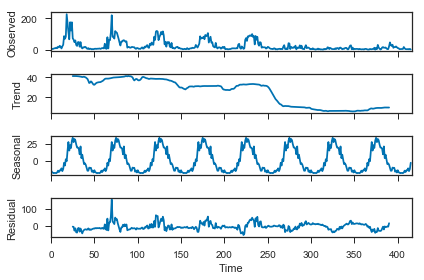

In [298]:
predcitions_gbrsj_series = pd.Series(np.append(predictions_gbrsj, predictions_gbriq))
decomposed = sm.tsa.seasonal_decompose(predcitions_gbrsj_series.values, model='additive', freq = 50)
decomposed.plot()
pyplot.show()

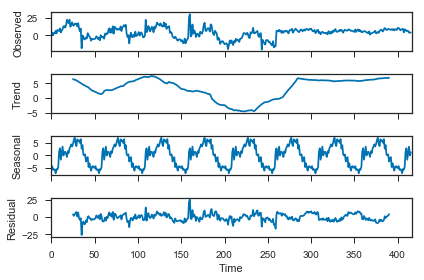

In [296]:
predcitions_svr_series = pd.Series(np.append(predictions_svrsj, predictions_svriq))
decomposed = sm.tsa.seasonal_decompose(predcitions_svr_series.values, model='additive', freq = 50)
decomposed.plot()
pyplot.show()

#### Summary of Results

### 6. c. Submission

###### Submission for SVR for both cities

In [254]:
predictionssvr = np.append(predictions_svriq, predictions_svrsj)
SVR_sub= pd.DataFrame()
SVR_sub['city'] = dengue_test.city
SVR_sub['year'] = dengue_test.year
SVR_sub['weekofyear']=dengue_test.weekofyear
SVR_sub['total_cases'] = predictionssvr.round()

In [255]:
SVR_sub.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,7.0
1,sj,2008,19,6.0
2,sj,2008,20,6.0
3,sj,2008,21,8.0
4,sj,2008,22,5.0


In [256]:
SVR_sub.total_cases = SVR_sub.total_cases.astype(int)

In [257]:
SVR_sub.to_csv('submission_SVR.csv', index=False)

###### Ranked 949 out of 2384  MAE 35.3245

##### Submission for GBR for both cities

In [258]:
predictionsgbr = np.append(predictions_gbriq, predictions_gbrsj)
GBR_sub= pd.DataFrame()
GBR_sub['city'] = dengue_test.city
GBR_sub['year'] = dengue_test.year
GBR_sub['weekofyear']=dengue_test.weekofyear
GBR_sub['total_cases'] = predictionsgbr.round()

In [259]:
GBR_sub.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,3.0
1,sj,2008,19,1.0
2,sj,2008,20,4.0
3,sj,2008,21,5.0
4,sj,2008,22,6.0


In [260]:
GBR_sub.total_cases = GBR_sub.total_cases.astype(int)

In [261]:
GBR_sub.to_csv('submission_GBR.csv', index=False)

###### MAE 38.4928

# Capstone Summary: Observations, Discoveries, Pitfalls, and Future Steps